# Modelling & Forecasting Default Rates of Corporate Loans
## Classical Time Series Models vs. Machine learning 

__Contributors:__ _Stress-Testing & Scenario Analysis_ - _Team Bravo: Translation of macro factors - AI/ML_ 

__Task:__ _Modelling the quanterly changes of the HSH default rate using macroeconomic data. Benchmarking linear vs. machine learning forecasting models_ 

### 0. First, let's load (and install where neccessary) the packages that we are using

In [290]:
### Load packages (and install the ones missing)
suppressMessages(if (!require("pacman")) install.packages("pacman", repos = "http://cran.us.r-project.org"))
pacman::p_load("readxl","Hmisc","mice","IRdisplay","VIM","car","Amelia","ggplot2", "dplyr", "caret", "broom",
                                "tibble","labeling", "digest", "VIM","curl", "devtools", "dataPreparation", 
                                "astsa", "ggfortify","tidyr", "prophet", "tseries","mombf","robustbase","forecast",
                                "caTools","mlbench",  "psych","astsa","nortest", "normtest" , "e1071", "prophet",
                                "tibble","labeling", "digest", "tseries", "robustbase","forecast","caTools",  "rpart",
                                "cluster","tidyquant", "nnet", "dataPreparation", "forecast", "neuralnet"                                    
                                )

# I. Introduction

### 1. What is the Probability of Default / Default Rate

- The Default rate __(AR = Ausfallrate)__ describes the ratio between actual defaulted loans and the avg. number of loans emitted by an institution over a certain period of time (usually the past year)


- The probability of default (PD) is a key credit risk parameter describing the likelihood of a credit default over a particular time horizon - usually 1 year. I.e it is basically an estimator for the future AR value.

### 2. Why is it useful to estimate the Default Rate

- Estimating default probabilities is the first step in assessing the credit exposure and potential losses faced by financial institutions


- Default probabilities are also the basic inputs when evaluating systemic risk and stress testing financial systems


- It has become more important in the last decade, as it serves as an important input factor for determining the minimum capital requirements for banks using IRB (internal-rated based) approach.

### 2.1 The concept of macroeconomic-based models

- Macroeconomic-based models are motivated by the observation that default rates in the financial, corporate, and household sectors increase during recessions. 



- This observation has led to the implementation of econometric models that attempt to explain default indicators, such as default probabilities or default rates, using macroeconomic variables.


- Macroeconomic models explain changes in the default rate out of macroeconomic conditions. These macroeconomic variables are cyclical indicators, e.g. GDP growth or interest rates, and financial market indicators, e.g.  stockmarket prices and stockmarket volatility


- Macroeconomic models can be classified into exogenous and endogenous models, i.e. whether the model allows feedback between financial distress and the explanatory economic variables. 

#### Caveats

- On the other hand, a disadvantage of macroeconomic models is that the time-span of the data needs to be longer than one  business cycle, otherwise the model would not capture the impact of the business cycle on default probabilities


- The first category of macroeconomic-based models assumes that the economic variables are exogenous and not affected by financial distress. 


#### 2.2 The general approach to exogeneous modelling is described by the following equation:

$$\text{default_rate_t} = g(x_1,x_2,\ldots, x_n) + \epsilon$$

- $X = (x_1, x_2, \ldots, x_n)$ a function of a set of economic variables and a random variable (like GDP growth f.ex)

#### 2.3 Our hypotheses and assumptions for the models:
1. Examined macroeconomic factors (GDP growth, interest rate, unemployment, etc.) have significant influence on the default rate in all of the models.
2. The PD will always over/underestimate the true AR, but we can model it more precisely than the baseline model
3. The baseline model is to assume the current AR value forward for the next period
4. Linear Regression can perform better than the Baseline Model
5. ML will perform better than our LR models



#### 2.4 ARs vs Logit ARs

- The aim here is to determine the estimation of the regression coefficients and the selection of the macroeconomic factors in such a way that they make economic sense within the framework of the respective model

- To achieve statistical quality of the estimates both Y and X may be suitably transformed.


The transformation used on the target variable is called logit transformation.

$$Logit_{AR} = \ln \frac{AR}{1-AR}$$

Why do we take all the trouble doing the transformation from probability to log odds?  

- One reason is that it is usually difficult to model a variable which has restricted range, such as probability. 
- This transformation is an attempt to get around the restricted range problem.  
- It maps probability ranging between 0 and 1 to log odds ranging from __negative infinity to positive infinity.__ 
- Another reason is that among all of the infinitely many choices of transformation, the log of odds is one of the easiest to understand and interpret.  

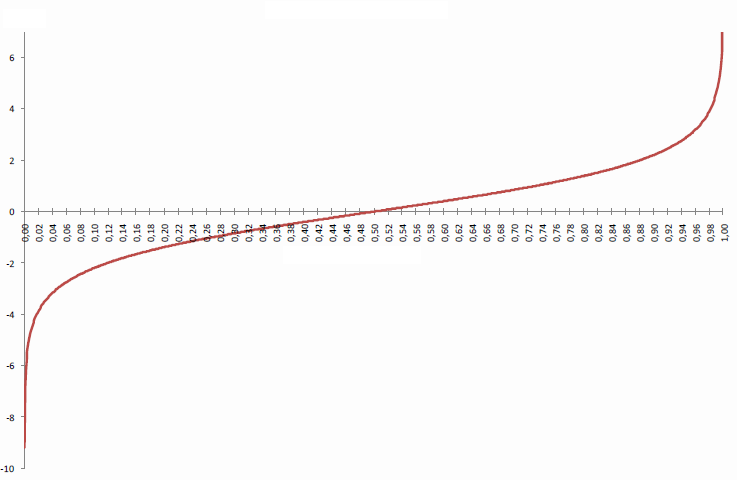

In [172]:
#The following diagram shows the course of the Logit-AR as a function of the AR. 
#It can be seen that the logit transformation does not alter the monotony, i. a high value for the Logit-AR means a big risk,
#analogous to the PD.
document_name = "Logit.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location) #should state "AR" and not "PD"

In addition to the logit transformation, it often makes sense not to describe the absolute values of the AR or Logit-AR by a model but their relative or absolute changes. These changes may occur over time, i. from the time t to the time t + 1 or by changing - for example, stressed - influence variables. Formally, this is expressed as follows:

$$\Delta \text{Logit_AR}_t := \text{Logit-AR}_t -\text{Logit-AR}_{t-1}$$

Forecasting forward that would lead to:

$$\text{Logit_AR}_{t+1} := \text{Logit-AR}_t + \Delta \text{Logit-AR}_{t+1}$$

And to bring it back to original AR-values:

$$\text{AR}_{t+1} = \frac{1}{1+\exp^{\text{-Logit_AR}_{t+1}}}\Leftrightarrow \text{AR}_{t+1} = \frac{\exp^{\text{Logit_AR}_{t+1}}}{1+\exp^{\text{Logit_AR}_{t+1}}}$$

### 3. What is a Time Series and how do we forecast

A time series is a sequence of observations taken sequentially in time. The purpose of time series analysis is generally twofold: 
- to understand or model the stochastic mechanisms that gives rise to an observed series
- to predict or forecast the future values of a series based on the history of that series

Time series analysis provides a body of techniques to better understand a dataset. Perhaps the most useful of these is the decomposition of a time series into 4 constituent parts:

- __Level__. The baseline value for the series if it were a straight line.
- __Trend__. The optional and often linear increasing or decreasing behavior of the series over time.
- __Seasonality__. The optional repeating patterns or cycles of behavior over time.
- __Noise__. The optional variability in the observations that cannot be explained by the model.

All time series have a level, most have noise, and the trend and seasonality are optional.

Model is being refit with current smoothing parameters but initial states are being re-estimated.
Set 'use.initial.values=TRUE' if you want to re-use existing initial values.


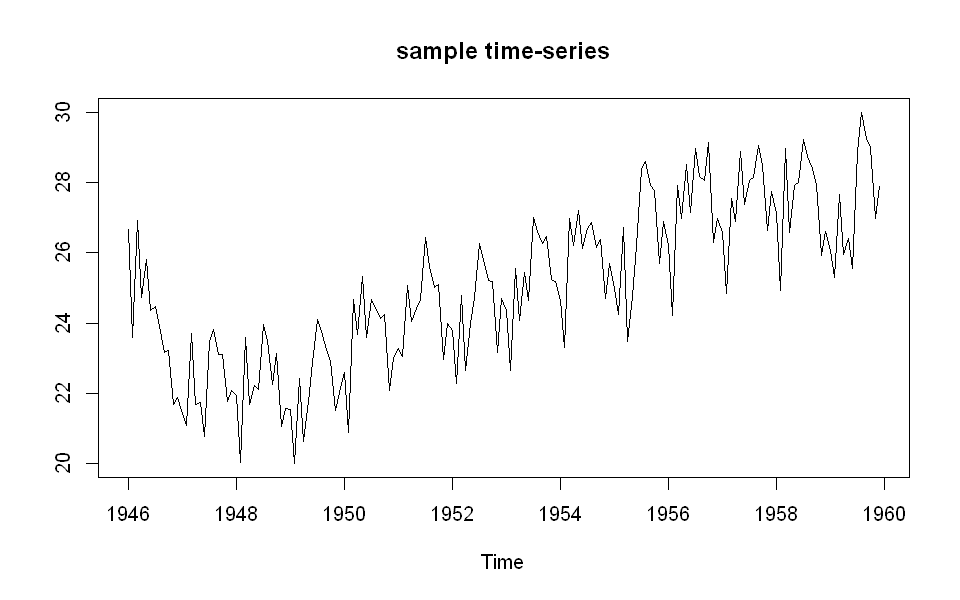

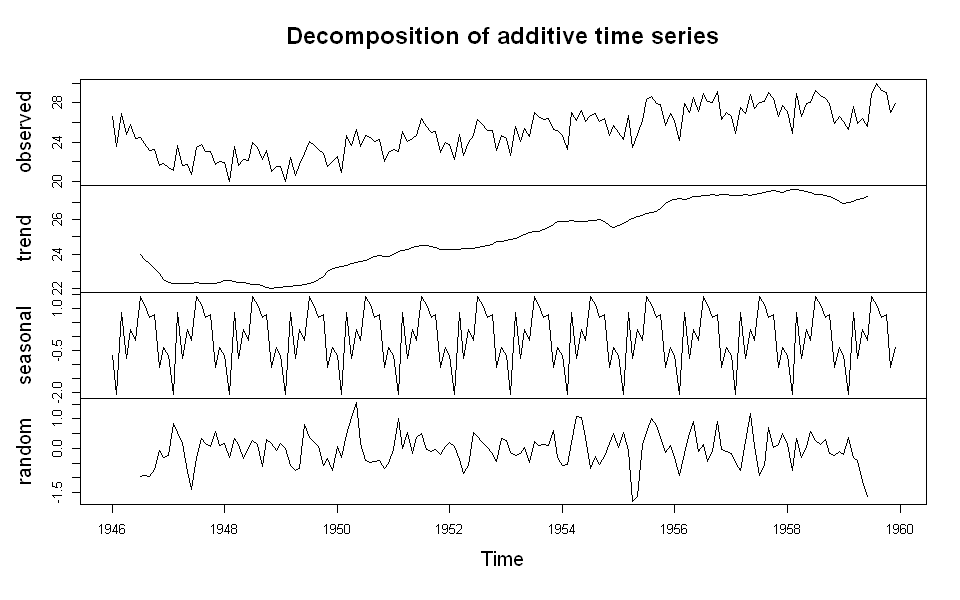

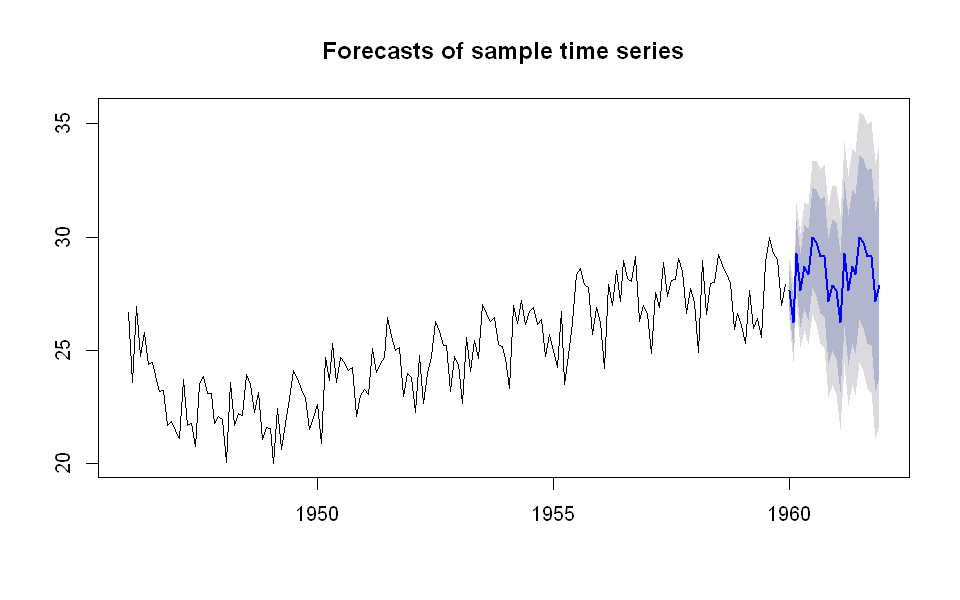

In [173]:
#Let's show a sample time series so people know what we are talking about
options(repr.plot.width = 8)
options(repr.plot.height = 5)
births <- scan("http://robjhyndman.com/tsdldata/data/nybirths.dat")
birthstimeseries <- ts(births, frequency=12, start=c(1946,1))
birthstimeseriescomponents <- decompose(birthstimeseries)
fit = ets(birthstimeseries)
fc <- forecast(birthstimeseries, model=fit)
plot.ts(birthstimeseries, ylab="", main = "sample time-series")
plot(birthstimeseriescomponents)
plot(fc, main = "Forecasts of sample time series")

### 4. Concerns of Forecasting

When forecasting, it is important to understand the goal. 
1. How much data do you have available? More data is often more helpful, offering greater opportunity for exploratory data analysis, model testing and tuning, and model fidelity.


2. What is the time horizon of predictions that is required? Short, medium or long term? Shorter time horizons are often easier to predict with higher confidence.


3. Can forecasts be updated frequently over time or must they be made once and remain static? Updating forecasts as new information becomes available often results in more accurate predictions.


4. At what temporal frequency are forecasts required? Often forecasts can be made at a lower or higher frequencies, allowing you to harness down-sampling, and up-sampling of data, which in turn can offer benefits while modeling.

__Remember: Time series data often requires cleaning, scaling, and even transformation before the actual modelling can take place__

### 5. Let's look at our HSH dataset

__Corporate Loans (AAA rated)__

The Corporates segment includes all corporate customers

__excluding:__
1. those already considered in the Shipping sub-portfolio "Corporates" 
2. aircraft financing (airline financing). 
3. also exclude leasing companies and leveraged finance businesses

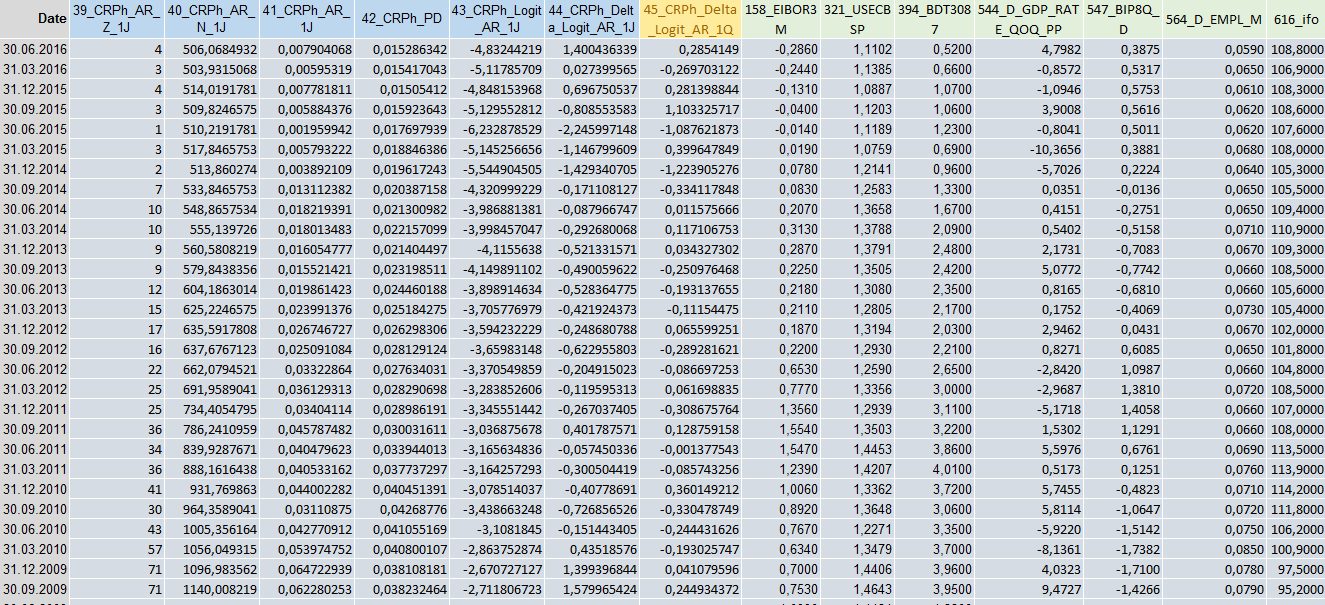

In [174]:
document_name = "HSH_Exceldatensatz.png"
file_location=paste(getwd(),"/", document_name, sep= "")
display_png(file=file_location)  

### Data description
As you can see there are multiple colored columns

- __grey__ (Date): The data ranges from __2006-09-30 to 2016-06-30__ (i.e 40 data points of quarterly data)


- __blue__: HSH data that we use as basis for our analysis


- __yellow__: HSH target variable (45_CRPh_Delta_Logit_AR_1Q), representing the quarterly change after being Logit transformed (more about the reasoning see below)


- __green__: Our selected macro features (GDP, Euribor, Ifo-Score, Employment, etc) which we will use for the default rate prediction

### 6. General Framework Overview
- Time series forecasting involves developing and using a predictive model on data where there is an ordered relationship between observations.


- The goal of this process is to get a “good enough” forecast model as fast as possible.


- This process may or may not deliver the best possible model, but it will deliver a good model: a model that is better than a baseline prediction, if such a model exists.


- Typically, this process will deliver a model that is 80% to 90% of what can be achieved on the problem.

### What are the inputs and outputs for our forecast?

__Inputs__:
- 158_EIBOR3M - __Euribor 3M__
- 321_USECBSP
- 394_BDT3087
- 544_D_GDP_RATE_QOQ_PP
- 547_BIP8Q_D
- 564_D_EMPL_M - __Employment Germany__
- 616_ifo - __Ifo Index__

__Outputs__:
- 45_CRPh_Delta_Logit_AR_1Q - __quarterly changes of Default Rate__

#### What are the endogenous and exogenous variables?
All our variables used are exogenous (macro data)

#### Are you working on a regression or classification predictive modeling problem?
We are working on a multivariate linear time-series regression model that enables us to do forecasts

#### Are you working on a univariate or multivariate time series problem?
We are working on a multivariate time series problem, because we are forecasting more than one value

_(Statisticians call it multivariate regression when you have multiple response variables, which is confusingly similar to "multiple regression" (multiple features to predict a single response).)_

#### Do you require a single-step or a multi-step forecast?
We use Multi-Step forecasting (4 quarters into the future (Q1, Q2, Q3, Q4))

#### Do you require a static or a dynamically updated model?

- We train our model using an anchored walk forward procedure 
- That means we train first on 12 data points to make 4 forecasts (the next 4 quarters). 
- Then we repeat the process and train on 13 data points (the old 12 plus the following quarter). 
- In this way we increase our training set one data point at the time until we reach the end of the time-series.
- see picture below

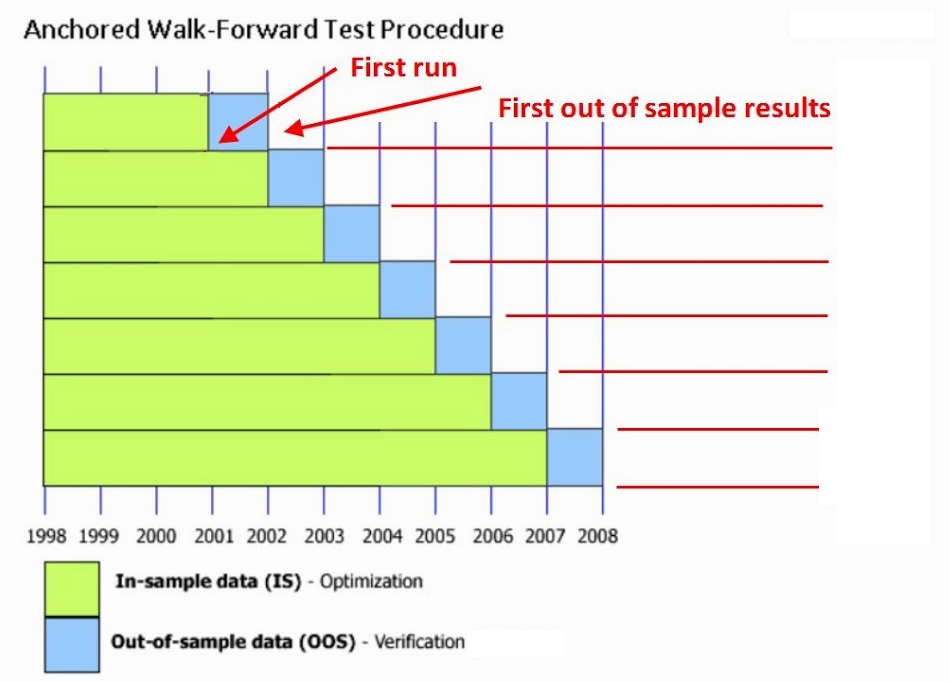

In [365]:
document_name = "WalkForward.png"
file_location=paste(getwd(),"/", document_name, sep= "")
display_png(file=file_location, width = 600, height = 600)  

# II. Exploratory Analysis

### 2. Now, let's import our adjusted datasheet from the HSH excel file

In [176]:
document_name = "20180816_ABT.xlsx"
file_location=paste(getwd(),"/", document_name, sep= "")
col_types <- c("date", rep("numeric", 14))#1 Date column and other numeric columns
suppressWarnings(
#select only the final sheet from the excel file
ABT <- read_excel(file_location, 
                  sheet = "Datensatz_v2", col_types = col_types))

### 3. Perform a few necessary transformations on the analytic base table (ABT)

In [177]:
ABT <- as.data.frame(ABT)#convert to dataframe
ABT$Date = as.Date(as.character(ABT$Date), "%Y-%m-%d")#convert to the right time-format
temp = colnames(ABT)[-1]#transform all columns, except for Date. Reason: a colname can't start with a number => not allowed in R)
temp = gsub("\\)", ".", temp)#replace special character ")" with "."
temp = gsub("\\(", ".", temp)#replace special character "(" with "."
new_column_names = c("Date", paste("pre_",temp, sep=""))
names(ABT) = new_column_names#replace now the col-names

### 4. Filter the data:

- We use the dplyr package for subsetting the dataframe. 
- Due to various recalibrations in the rating module, the internal time series starts from the third quarter of 2006 onwards only. (see "Szenarioanalyse-v3.04.pdf")
- Therefore, the analysis is based on the interval: 2006-09-30 to 2016-06-30.

### 5. Let's inspect the first rows of our ABT 

In [178]:
#Let's inspect 1yr of data
head(ABT,5)
cat("Number of columns:", ncol(ABT),"\n")
cat("Number of rows:", nrow(ABT))

Date,pre_39_CRPh_AR_Z_1J,pre_40_CRPh_AR_N_1J,pre_41_CRPh_AR_1J,pre_42_CRPh_PD,pre_43_CRPh_Logit_AR_1J,pre_44_CRPh_Delta_Logit_AR_1J,pre_45_CRPh_Delta_Logit_AR_1Q,pre_158_EIBOR3M,pre_321_USECBSP,pre_394_BDT3087,pre_544_D_GDP_RATE_QOQ_PP,pre_547_BIP8Q_D,pre_564_D_EMPL_M,pre_616_ifo
2016-06-30,4,506.0684932,0.007904068430,0.01528634172,-4.832442190,1.40043633933,0.2854149004,-0.286,1.1102,0.52,4.7981767756,0.3875337290,0.059,108.8
2016-03-31,3,503.9315068,0.005953189986,0.01541704297,-5.117857090,0.02739956546,-0.2697031222,-0.244,1.1385,0.66,-0.8571599625,0.5317147822,0.065,106.9
2015-12-31,4,514.0191781,0.007781810817,0.01505412032,-4.848153968,0.69675053686,0.2813988440,-0.131,1.0887,1.07,-1.0946481185,0.5753389589,0.061,108.3
2015-09-30,3,509.8246575,0.005884376041,0.01592364297,-5.129552812,-0.80855358326,1.1033257172,-0.040,1.1203,1.06,3.9008382283,0.5616064566,0.062,108.6
2015-06-30,1,510.2191781,0.001959942007,0.01769793889,-6.232878529,-2.24599714825,-1.0876218735,-0.014,1.1189,1.23,-0.8041262671,0.5011319928,0.062,107.6


Number of columns: 15 
Number of rows: 40

### 6. Check for duplicate columns and remove them

In [179]:
cat("Number of columns before removal of duplicates:", ncol(ABT),"\n")
ABT = ABT[!duplicated(lapply(ABT, digest))] #Delta_Miete_H_real und Delta_Lrst_B are equal!
cat("Number of columns after removal of duplicates:", ncol(ABT), "\n")

Number of columns before removal of duplicates: 15 
Number of columns after removal of duplicates: 15 


### 7. Remove features that contain NA's

In [180]:
#1 check for NAs and remove columns where they exist (I don't want to impute our feature data)
ABT_features = ABT %>%
select(-contains("_CRPh_"), -contains("Date"))

ABT_non_features = ABT %>%
select(contains("Date"), contains("_CRPh_"))

cat("Number of overall features:", ncol(ABT_features),"\n")

na_columns=sapply(ABT_features, function(y) sum(is.na(y)))
null_columns = sapply(ABT_features, is.null)    

ABT_features=ABT_features[,names(na_columns[na_columns==0])]#remove all columns that have an NA in it
cat("Number of 'clean' features:", ncol(ABT_features))

Number of overall features: 7 
Number of 'clean' features: 7

### 8. Check for collinearity among features

Collinearity is a linear association between two explanatory variables. Two variables are perfectly collinear if there is an exact linear relationship between them. For example, $X_1$ $X_2$  are perfectly collinear if there exist parameters $\lambda _{0}$ and $\lambda _{1}$ such that, for all observations $i$, we have

$$X_{2i} = \lambda_0 + \lambda_1 \cdot X_{1i}$$
- We have 477 features, but as we will see below, there exist many pairs that show high correlation to one another, even as high as 99.9%.


- This could lead to a problem regarding our predicitons.


- As a result we will remove one of the pairs, that have correlation > 99.9%.

In [181]:
#The function “mosthighlycorrelated()” will print out the linear correlation coefficients for each pair of variables in our
#data set, ordered by size of the correlation coefficient. This lets you see very easily which pair of variables are most highly 
#correlated

mosthighlycorrelated <- function(mydataframe,numtoreport)
{
# find the correlations
cormatrix <- cor(mydataframe)
# set the correlations on the diagonal or lower triangle to zero,
# so they will not be reported as the highest ones:
diag(cormatrix) <- 0
cormatrix[lower.tri(cormatrix)] <- 0
# flatten the matrix into a dataframe for easy sorting
fm <- as.data.frame(as.table(cormatrix))
# assign human-friendly names
names(fm) <- c("First.Variable", "Second.Variable","Correlation")
fm$Correlation = abs(fm$Correlation)
# sort and print the top n correlations
head(fm[order(abs(fm$Correlation),decreasing=T),],n=numtoreport)
}

temp = mosthighlycorrelated(ABT_features, 100000000)

temp = temp%>%
filter(abs(Correlation) > 0.5)%>%
distinct(First.Variable)

cat("How many features have correlation > 50%:", length(temp$First.Variable))

#if you want to remove them, run this following line of code:
#ABT_features=ABT_features[,!names(ABT_features) %in% temp$First.Variable]

How many features have correlation > 50%: 3

### 9. Further filtering of unhelpful variables

The first thing to do, in order to make computation fast, would be to filter useless variables:


- Constant variables
- Variables that exist twice (for example feature1 == feature2)
- Variables that are exact bijections (for example col1 = A, B, B, A and col2 = 1, 2, 2, 1)

In [182]:
constant_cols <- whichAreConstant(ABT_features)
double_cols <- whichAreInDouble(ABT_features)
bijections_cols <- whichAreBijection(ABT_features, verbose = F) # The output is just "too long" :)

[1] "whichAreConstant: it took me 0.42s to identify 0 constant column(s)"
[1] "whichAreInDouble: it took me 0.39s to identify 0 column(s) to drop."


In [183]:
#if you want to remove them, run this following line of code:
#ABT_features = ABT_features%>% select(-bijections_cols)

In [184]:
#Merge the remaining columns (features+non-features) back together
ABT = cbind(ABT_non_features, ABT_features)
cat("Number of columns:", ncol(ABT),"\n")
cat("Number of rows:", nrow(ABT))

Number of columns: 15 
Number of rows: 40

### 10. Visualizing important variables

Here we want to show how the PD estimates from the HSH model measures up against their actual AR values. In addition we plot the yearly and quarterly changes or our logit-AR.

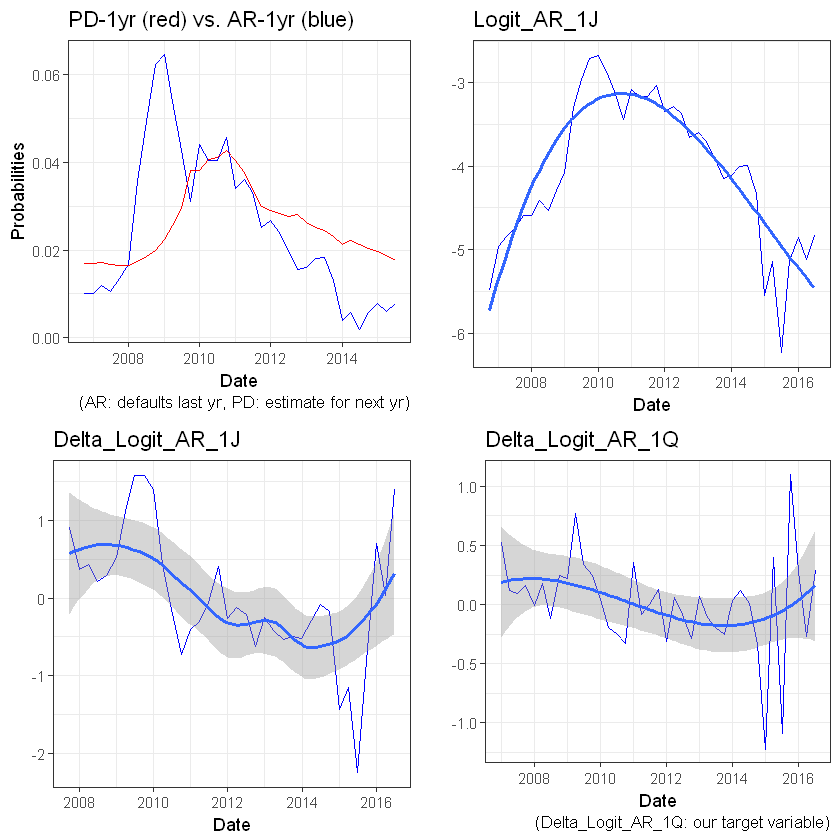

In [185]:
#First we need to shift the AR values down, since they are a description of the last 12 months. The shift makes sure
#that the PD and AR can be compared against
temp1 = ABT$pre_41_CRPh_AR_1J
temp1 = c(rep(NA,4), temp1[1:(length(temp1)-4)])
temp2 = ABT$pre_42_CRPh_PD

options(repr.plot.width = 7)#7 is default
options(repr.plot.height = 7)#7 is default

p1 = ggplot() +
    geom_line(data = cbind(ABT%>%select(Date),temp1,temp2)%>%na.omit(),
              aes(x = Date, y = temp1, group = 1),color="blue") +
    geom_line(data = cbind(ABT%>%select(Date),temp1,temp2)%>%na.omit(),
              aes(x = Date, y = temp2, group = 1),color="red") +
    #geom_point(na.rm = TRUE) +
    ggtitle("PD-1yr (red) vs. AR-1yr (blue)")+
    ylab("Probabilities")+
    labs(caption = "(AR: defaults last yr, PD: estimate for next yr)")+
    theme_bw()

#plot Delta_Logit_AR
p2 = ggplot(data = ABT%>%select(contains("Date"), contains("44_CRPh_Delta_Logit_AR_1J"))%>%na.omit(), aes(x = Date, y = pre_44_CRPh_Delta_Logit_AR_1J)) + 
    #geom_point(na.rm = TRUE) +
    geom_line(color="blue") +
    geom_smooth(method ="loess")+
    ggtitle("Delta_Logit_AR_1J")+
    ylab("")+
    theme_bw()


#plot Logit_AR
p3 = ggplot(data = ABT%>%select(contains("Date"), contains("pre_43_CRPh_Logit_AR_1J"))%>%na.omit(), aes(x = Date, y = pre_43_CRPh_Logit_AR_1J)) + 
    #geom_point(na.rm = TRUE) +
    geom_line(color="blue") +
    geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), se = FALSE)+
    ggtitle("Logit_AR_1J")+
    ylab("")+
    theme_bw()

#plot Delta_Logit_AR_1Q
p4 = ggplot(data = ABT%>%select(contains("Date"), contains("45_CRPh_Delta_Logit_AR_1Q"))%>%na.omit(), aes(x = Date, y = pre_45_CRPh_Delta_Logit_AR_1Q)) + 
    #geom_point(na.rm = TRUE) +
    geom_line(color="blue") +
    geom_smooth(method = lm, formula = y ~ splines::bs(x, 3))+
    ggtitle("Delta_Logit_AR_1Q")+
    labs(caption = "(Delta_Logit_AR_1Q: our target variable)")+
    ylab("")+
    theme_bw()

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

multiplot(p1, p2, p3, p4, cols=2)

### Conclusion:

- We see that the PD-estimates done by HSH fail to accurately model the actual default rate. (See Top Left plot)
- It overestimates most of the time, and underestimates when needed the most: during a crisis (see 2008-2009)
- '09 ~ 60 defaults per 1000 vs 22 defaults estimated
- locally weighted scatterplot smoothing (LOESS) and spline interpolation used for smoothing shows that we can merely predict trends at best, but fail at precise forecasts

### Note: 
- the average PD at time t (in years) is a point estimate for the default rate (AR) at time t+1
- it's not clear from the documentation that HSH correctly placed them on the same timestamp

__=> Going forward we will use the Logit-AR_1Q as our target variable that we try to estimate. I.e the quarterly change in default rates__


In [186]:
start_date = "2006-12-31" #missing values due to differencing to get the quarterly rate (see excelsheet)
end_date = "2016-06-30"

ABT = ABT%>%
filter(Date>=start_date & Date <= end_date)

ABT_features = ABT %>%
select(-contains("_CRPh_"))

### 11. Autocorrelation

As we have seen in our previous plots, the default rate itself looks relatively "smooth", however the quarterly changes are not. They seem to have a somewhat random pattern. Let us investigate that through the use of an autocorrelation plot.

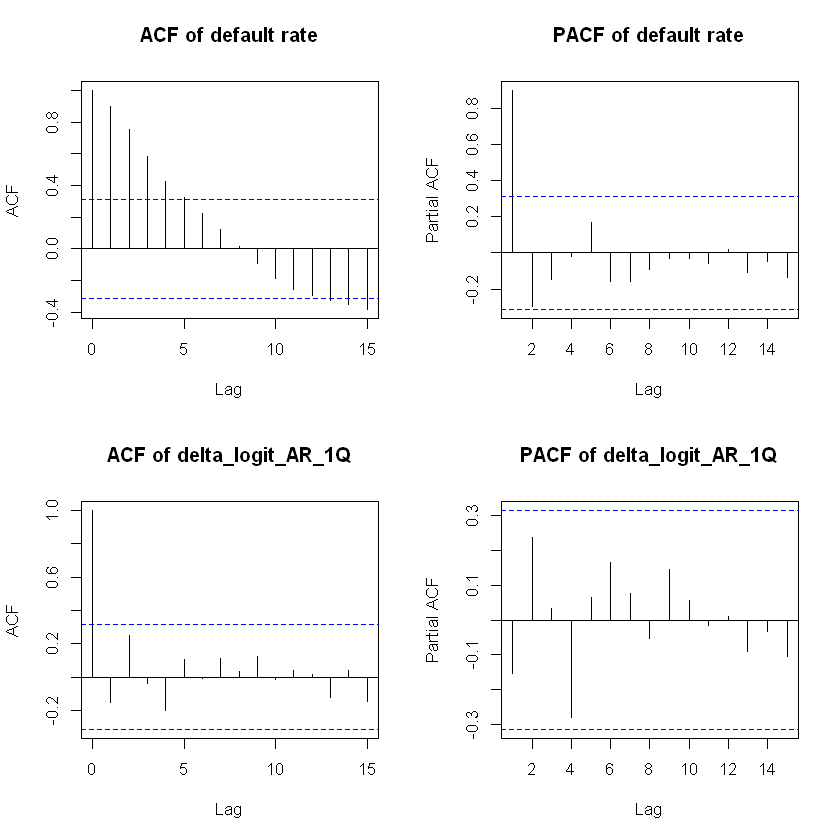

In [187]:
par(mfrow=c(2,2))
acf(ABT$pre_41_CRPh_AR_1J, main = "ACF of default rate")
pacf(ABT$pre_41_CRPh_AR_1J, main = "PACF of default rate")
acf(ABT$pre_45_CRPh_Delta_Logit_AR_1Q, main = "ACF of delta_logit_AR_1Q")
pacf(ABT$pre_45_CRPh_Delta_Logit_AR_1Q, main = "PACF of delta_logit_AR_1Q")

### Conclusion
- The partial autocorrelation of an AR(p) process is zero at lag p + 1 and greater, so the appropriate maximum lag is the one beyond which the partial autocorrelations are all zero.


- The PACF of the default rate shows a significant lag indicating the last quarter value to be correlating strongly with the succeeding value.


- That is not surprising, however, as next quarter default rates contain 3 out of 4 "old" values. After all, by design, the default rate appears very similar to a moving average.


- On the other hand we observe that the quarterly changes are quite random and not suited for any type of ARIMA model

#### Let's decompose our target variable to get a look on its components

Model is being refit with current smoothing parameters but initial states are being re-estimated.
Set 'use.initial.values=TRUE' if you want to re-use existing initial values.


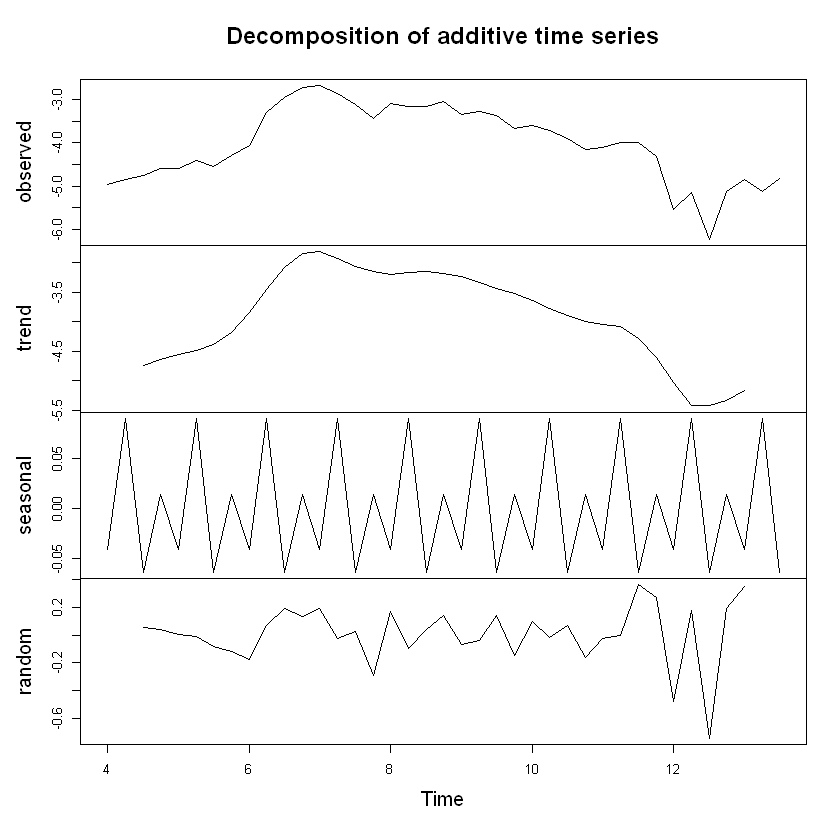

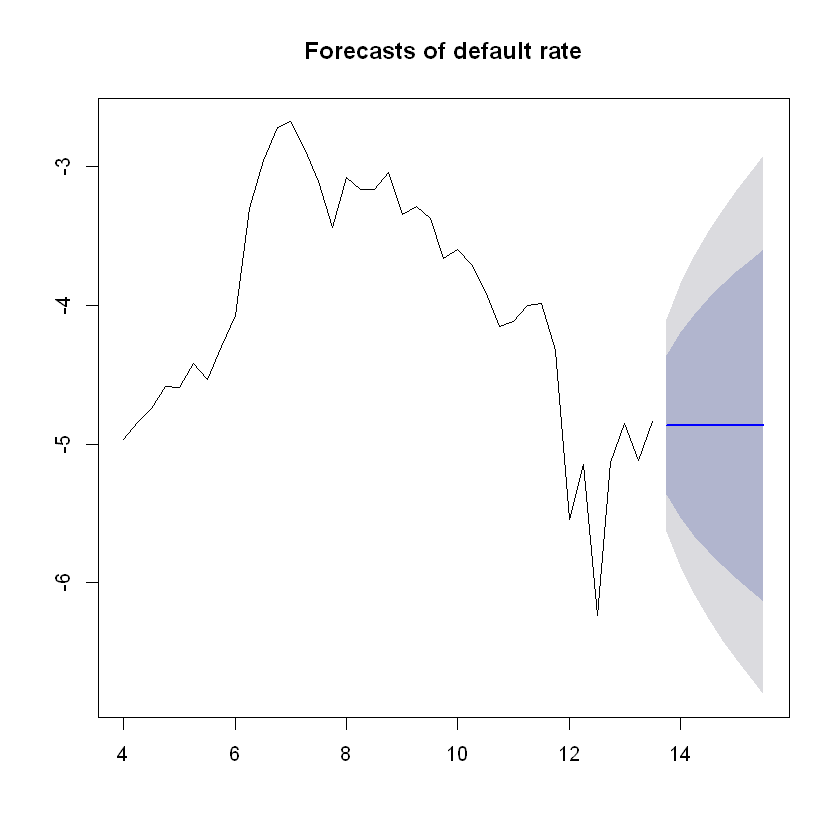

In [188]:
a <- ts(rev(ABT$pre_43_CRPh_Logit_AR_1J), start = 4, frequency=4) #we plotted the actual default rates and not the changes! 
b <- decompose(a)
plot(b)
fit = ets(a)
fc <- forecast(a, model=fit)
plot(fc, main = "Forecasts of default rate")

### Conclusion:

We can see that based on the thin data history we get forecasts with huge error margins => it will be a difficult task to do any sort of forecast here, both linear or machine learning.

### 12. Visualizing the features

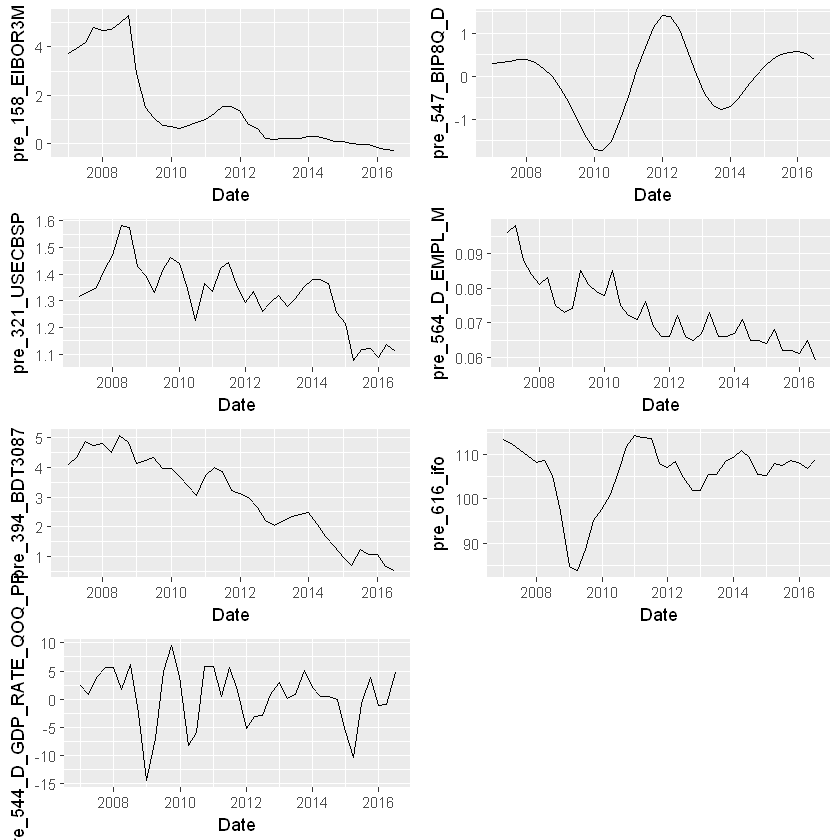

In [189]:
#ggplot(ABT_features$Date, ABT_features$pre_158_EIBOR3M)

p1 = ggplot(data = ABT_features, aes(x = Date, y = pre_158_EIBOR3M)) +
  geom_line()
p2 = ggplot(data = ABT_features, aes(x = Date, y = pre_321_USECBSP)) +
  geom_line()
p3 = ggplot(data = ABT_features, aes(x = Date, y = pre_394_BDT3087)) +
  geom_line()
p4 = ggplot(data = ABT_features, aes(x = Date, y = pre_544_D_GDP_RATE_QOQ_PP)) +
  geom_line()
p5 = ggplot(data = ABT_features, aes(x = Date, y = pre_547_BIP8Q_D)) +
  geom_line()
p6 = ggplot(data = ABT_features, aes(x = Date, y = pre_564_D_EMPL_M)) +
  geom_line()
p7 = ggplot(data = ABT_features, aes(x = Date, y = pre_616_ifo)) +
  geom_line()

multiplot(p1,p2,p3,p4,p5,p6,p7,cols = 2)

### 13. Visualizing the target variable in combination with its features

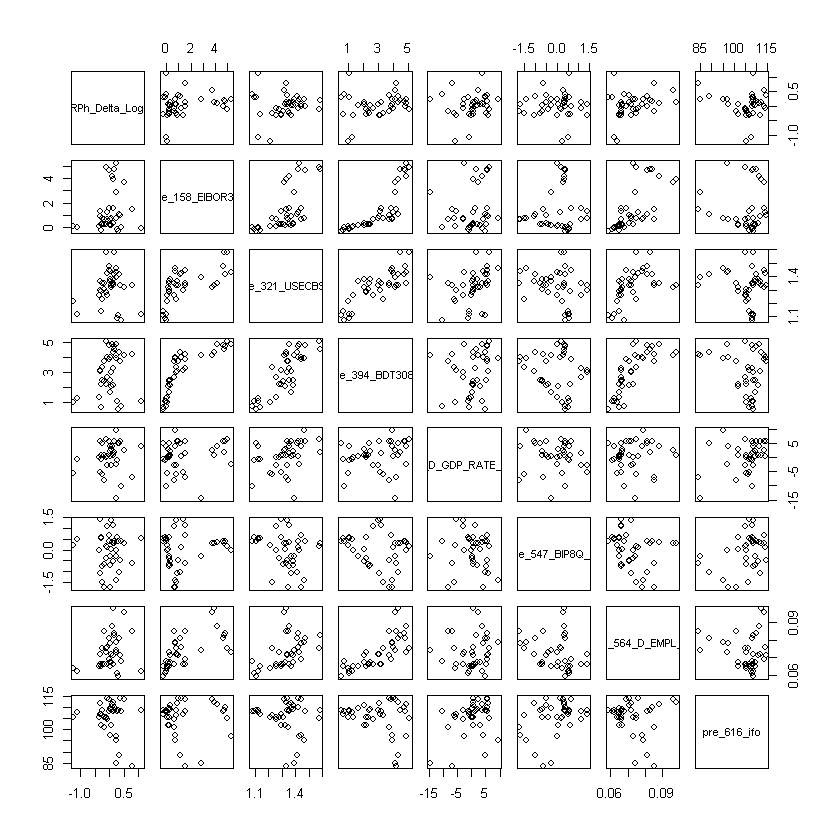

In [190]:
temp = cbind(ABT%>%select(pre_45_CRPh_Delta_Logit_AR_1Q),ABT[,9:15])
pairs(temp)

### Conclusion

We can see that our Delta_Logit_AR_1Q target variable __doesn't show a strong linear__ relationship with its features (see top row, or first column)

## III. Modelling

### 1. We first illustrate the increasing training window for our anchored walk forward procedure

In [191]:
options(repr.plot.width = 4)#7 is default
options(repr.plot.height = 4)#7 is default
p1 = ABT %>%
    select(Date, pre_45_CRPh_Delta_Logit_AR_1Q)%>%
    na.omit()%>%
    ggplot(aes(Date, pre_45_CRPh_Delta_Logit_AR_1Q))+
    ylab("")+
# Train Region
    geom_rect(xmin = as.numeric(ymd("2006-12-31")),
              xmax = as.numeric(ymd("2009-09-30")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[9]])+
    annotate("text", x = ymd("2008-06-01"), y = 1,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
    geom_rect(xmin = as.numeric(ymd("2009-12-31")), 
              xmax = as.numeric(ymd("2010-09-30")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[3]])+
    annotate("text", x = ymd("2010-04-01"), y = 1,
             color = palette_light()[[1]], label = "Validation\n Region")+
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta_Logit_AR_1Q",
         subtitle = "1st iteration: Train and Validation region shown")

In [192]:
options(repr.plot.width = 4)#7 is default
options(repr.plot.height = 4)#7 is default
p2 = ABT %>%
    select(Date, pre_45_CRPh_Delta_Logit_AR_1Q)%>%
    na.omit()%>%
    ggplot(aes(Date, pre_45_CRPh_Delta_Logit_AR_1Q))+
    ylab("")+
# Train Region
    geom_rect(xmin = as.numeric(ymd("2006-12-31")),
              xmax = as.numeric(ymd("2010-09-30")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[9]])+
    annotate("text", x = ymd("2009-06-01"), y = 1,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
    geom_rect(xmin = as.numeric(ymd("2010-12-31")), 
              xmax = as.numeric(ymd("2011-09-30")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[3]])+
    annotate("text", x = ymd("2011-04-01"), y = 1,
             color = palette_light()[[1]], label = "Validation\n Region")+
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta_Logit_AR_1Q",
         subtitle = "5th iteration: Train and Validation region shown")

In [193]:
options(repr.plot.width = 4)#7 is default
options(repr.plot.height = 4)#7 is default
p3 = ABT %>%
    select(Date, pre_45_CRPh_Delta_Logit_AR_1Q)%>%
    na.omit()%>%
    ggplot(aes(Date, pre_45_CRPh_Delta_Logit_AR_1Q))+
    ylab("")+
# Train Region
    geom_rect(xmin = as.numeric(ymd("2006-12-31")),
              xmax = as.numeric(ymd("2012-03-31")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[9]])+
    annotate("text", x = ymd("2010-06-01"), y = 1,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
    geom_rect(xmin = as.numeric(ymd("2012-06-30")), 
              xmax = as.numeric(ymd("2013-03-31")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
              fill = palette_light()[[3]])+
    annotate("text", x = ymd("2013-04-01"), y = 1,
             color = palette_light()[[1]], label = "Validation\n Region")+
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta_Logit_AR_1Q",
         subtitle = "20th iteration: Train and Validation region shown")

In [194]:
options(repr.plot.width = 4)#7 is default
options(repr.plot.height = 4)#7 is default
p4 = ABT %>%
    select(Date, pre_45_CRPh_Delta_Logit_AR_1Q)%>%
    na.omit()%>%
    ggplot(aes(Date, pre_45_CRPh_Delta_Logit_AR_1Q))+
    ylab("")+
# Train Region
    geom_rect(xmin = as.numeric(ymd("2006-12-31")),
              xmax = as.numeric(ymd("2015-06-30")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[9]])+
    annotate("text", x = ymd("2011-06-01"), y = 1,
             color = palette_light()[[1]], label = "Train Region")+
# Validation Region
    geom_rect(xmin = as.numeric(ymd("2015-09-30")),
              xmax = as.numeric(ymd("2016-06-30")),
              ymin = -1.5, ymax = Inf, alpha = 0.02,
             fill = palette_light()[[3]])+
    annotate("text", x = ymd("2016-01-01"), y = 1,
             color = palette_light()[[1]], label = "Validation\n Region")+
    geom_line(col = palette_light()[1]) +
    geom_point(col = palette_light()[1]) +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = "Delta_Logit_AR_1Q",
         subtitle = "27th(last) iteration: Train and Validation region shown")

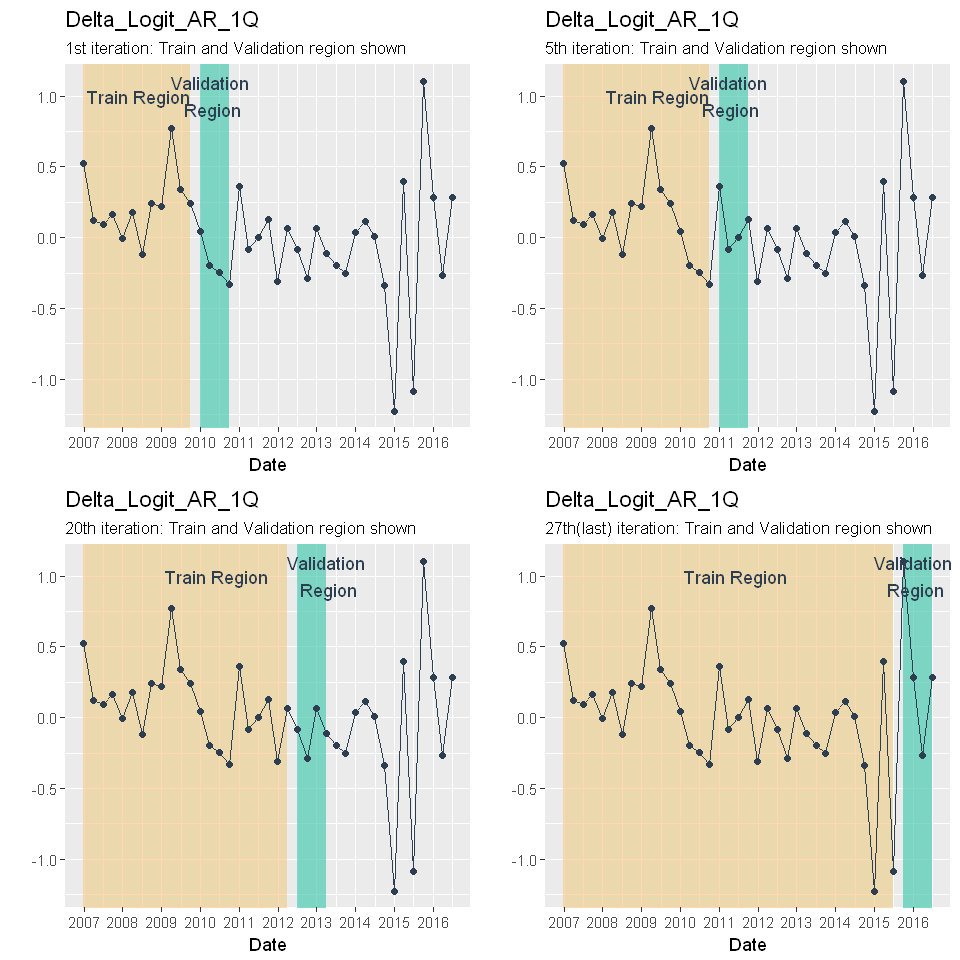

In [195]:
options(repr.plot.width = 8)#7 is default
options(repr.plot.height = 8)#7 is default
multiplot(p1, p3, p2, p4, cols=2)

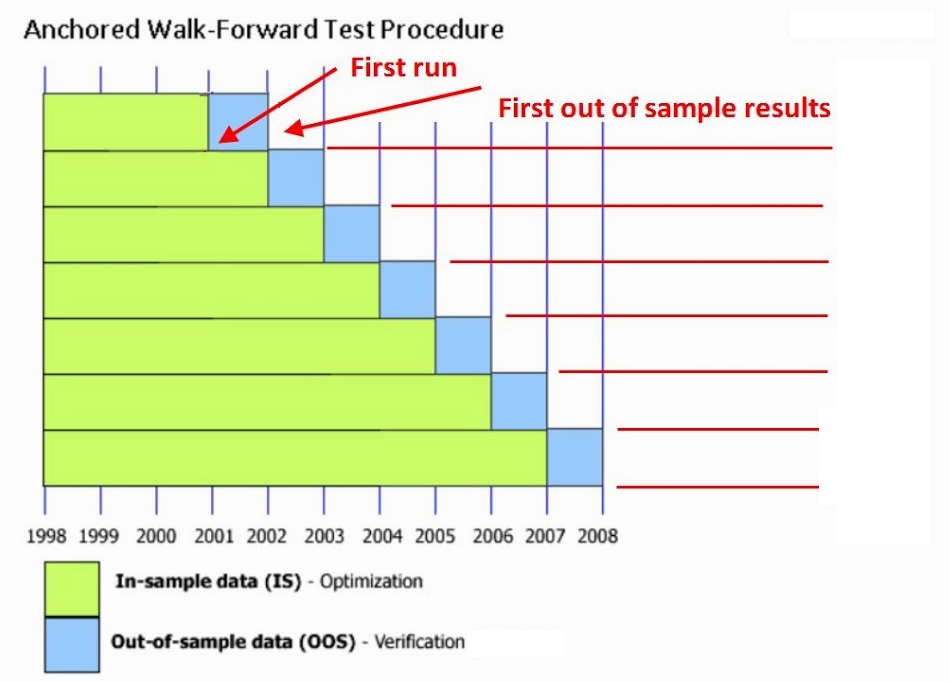

In [366]:
document_name = "WalkForward.png"
file_location=paste(getwd(),"/", document_name, sep= "")
display_png(file=file_location, width = 600, height = 600)  

### 2. Model preparation 

We create our increasing window as seen in the above plots. Our final goal will be to create iterative predictions through various models which we will benchmark against our true default rates. We cannot increase our window all the way to the end and thus have to scrap the last 5 rows because we would not be able to benchmark those last forecasts against anything - the true default rates obiously are not known yet.

In [197]:
#Here we create the final df that is going to get used for modelling
df = ABT_features
df$Q1_forecast = c(rep(NA,1), ABT$pre_45_CRPh_Delta_Logit_AR_1Q[1:(length(ABT$pre_45_CRPh_Delta_Logit_AR_1Q)-1)])
df$Q2_forecast = c(rep(NA,2), ABT$pre_45_CRPh_Delta_Logit_AR_1Q[1:(length(ABT$pre_45_CRPh_Delta_Logit_AR_1Q)-2)])
df$Q3_forecast = c(rep(NA,3), ABT$pre_45_CRPh_Delta_Logit_AR_1Q[1:(length(ABT$pre_45_CRPh_Delta_Logit_AR_1Q)-3)])
df$Q4_forecast = c(rep(NA,4), ABT$pre_45_CRPh_Delta_Logit_AR_1Q[1:(length(ABT$pre_45_CRPh_Delta_Logit_AR_1Q)-4)])
df_complete =df[complete.cases(df), ]#notation ok?
df_complete_scaled <- df_complete%>%mutate_at(colnames(ABT_features[,-1]), funs(c(scale(.))))#scale features!

### 3. Model Types

### 3.2 Linear Regression
The aim of linear regression is to model a continuous variable $Y$ as a mathematical function of one or more $X$ variable(s), so that we can use this regression model to predict the Y when only the X is known. This mathematical equation for one variable can be written as follows:

$$Y = \beta_1 + \beta_2 \cdot X +\epsilon$$

where, $\beta_1$ is the intercept and $\beta_2$ is the slope. Collectively, they are called regression coefficients. $\epsilon$ is the error term, the part of $Y$ the regression model is unable to explain.

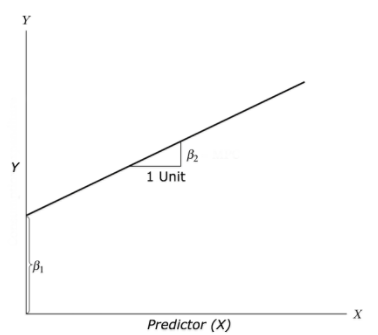

In [255]:
document_name = "LinearReg.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location)  

### 3.3 Neural Networks

#### Introduction

A Neural Network is an information-processing machine and can be viewed as analogous to human nervous system. Just like human nervous system, which is made up of interconnected neurons, a neural network is made up of interconnected information processing units. The information processing units do not work in a linear manner. In fact, neural network draws its strength from parallel processing of information, which allows it to deal with non-linearity. Neural network becomes handy to infer meaning and detect patterns from complex data sets.

A Neural network is considered as one of the most useful technique in the world of data analytics. However, it is complex and is often regarded as a black box, i.e. users view the input and output of a neural network but remain clueless about the knowledge generating process. We hope that the article will help readers learn about the internal mechanism of a neural network and get hands-on experience to implement it in R.

#### The Basics of Neural Network
A neural network is a model characterized by an activation function, which is used by interconnected information processing units to transform input into output. A neural network has always been compared to human nervous system. Information in passed through interconnected units analogous to information passage through neurons in humans. The first layer of the neural network receives the raw input, processes it and passes the processed information to the hidden layers. The hidden layer passes the information to the last layer, which produces the output. The advantage of neural network is that it is adaptive in nature. It learns from the information provided, i.e. trains itself from the data, which has a known outcome and optimizes its weights for a better prediction in situations with unknown outcome.

A perceptron, viz. single layer neural network, is the most basic form of a neural network. A perceptron receives multidimensional input and processes it using a weighted summation and an activation function. It is trained using a labeled data and learning algorithm that optimize the weights in the summation processor. A major limitation of perceptron model is its inability to deal with non-linearity. A multilayered neural network overcomes this limitation and helps solve non-linear problems. The input layer connects with hidden layer, which in turn connects to the output layer. The connections are weighted and weights are optimized using a learning rule.

There are many learning rules that are used with neural network:

a) least mean square

b) gradient descent;

c) newton’s rule;

d) conjugate gradient etc.

The learning rules can be used in conjunction with backpropgation error method. The learning rule is used to calculate the error at the output unit. This error is backpropagated to all the units such that the error at each unit is proportional to the contribution of that unit towards total error at the output unit. The errors at each unit are then used to optimize the weight at each connection. Figure 1 displays the structure of a simple neural network model for better understanding.

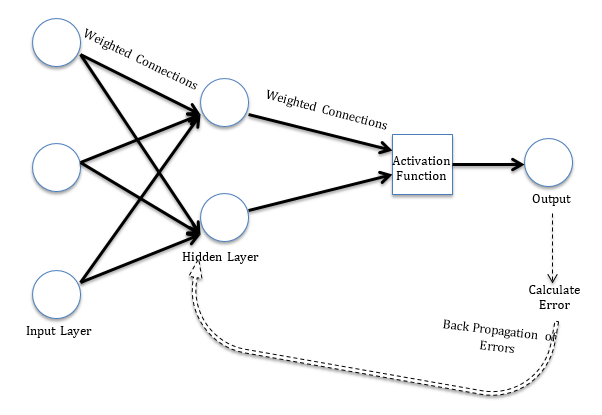

In [256]:
document_name = "nnet.png"
file_location=paste(getwd(),"/", document_name, sep= "")

display_png(file=file_location) 

#### Overview of other Networks

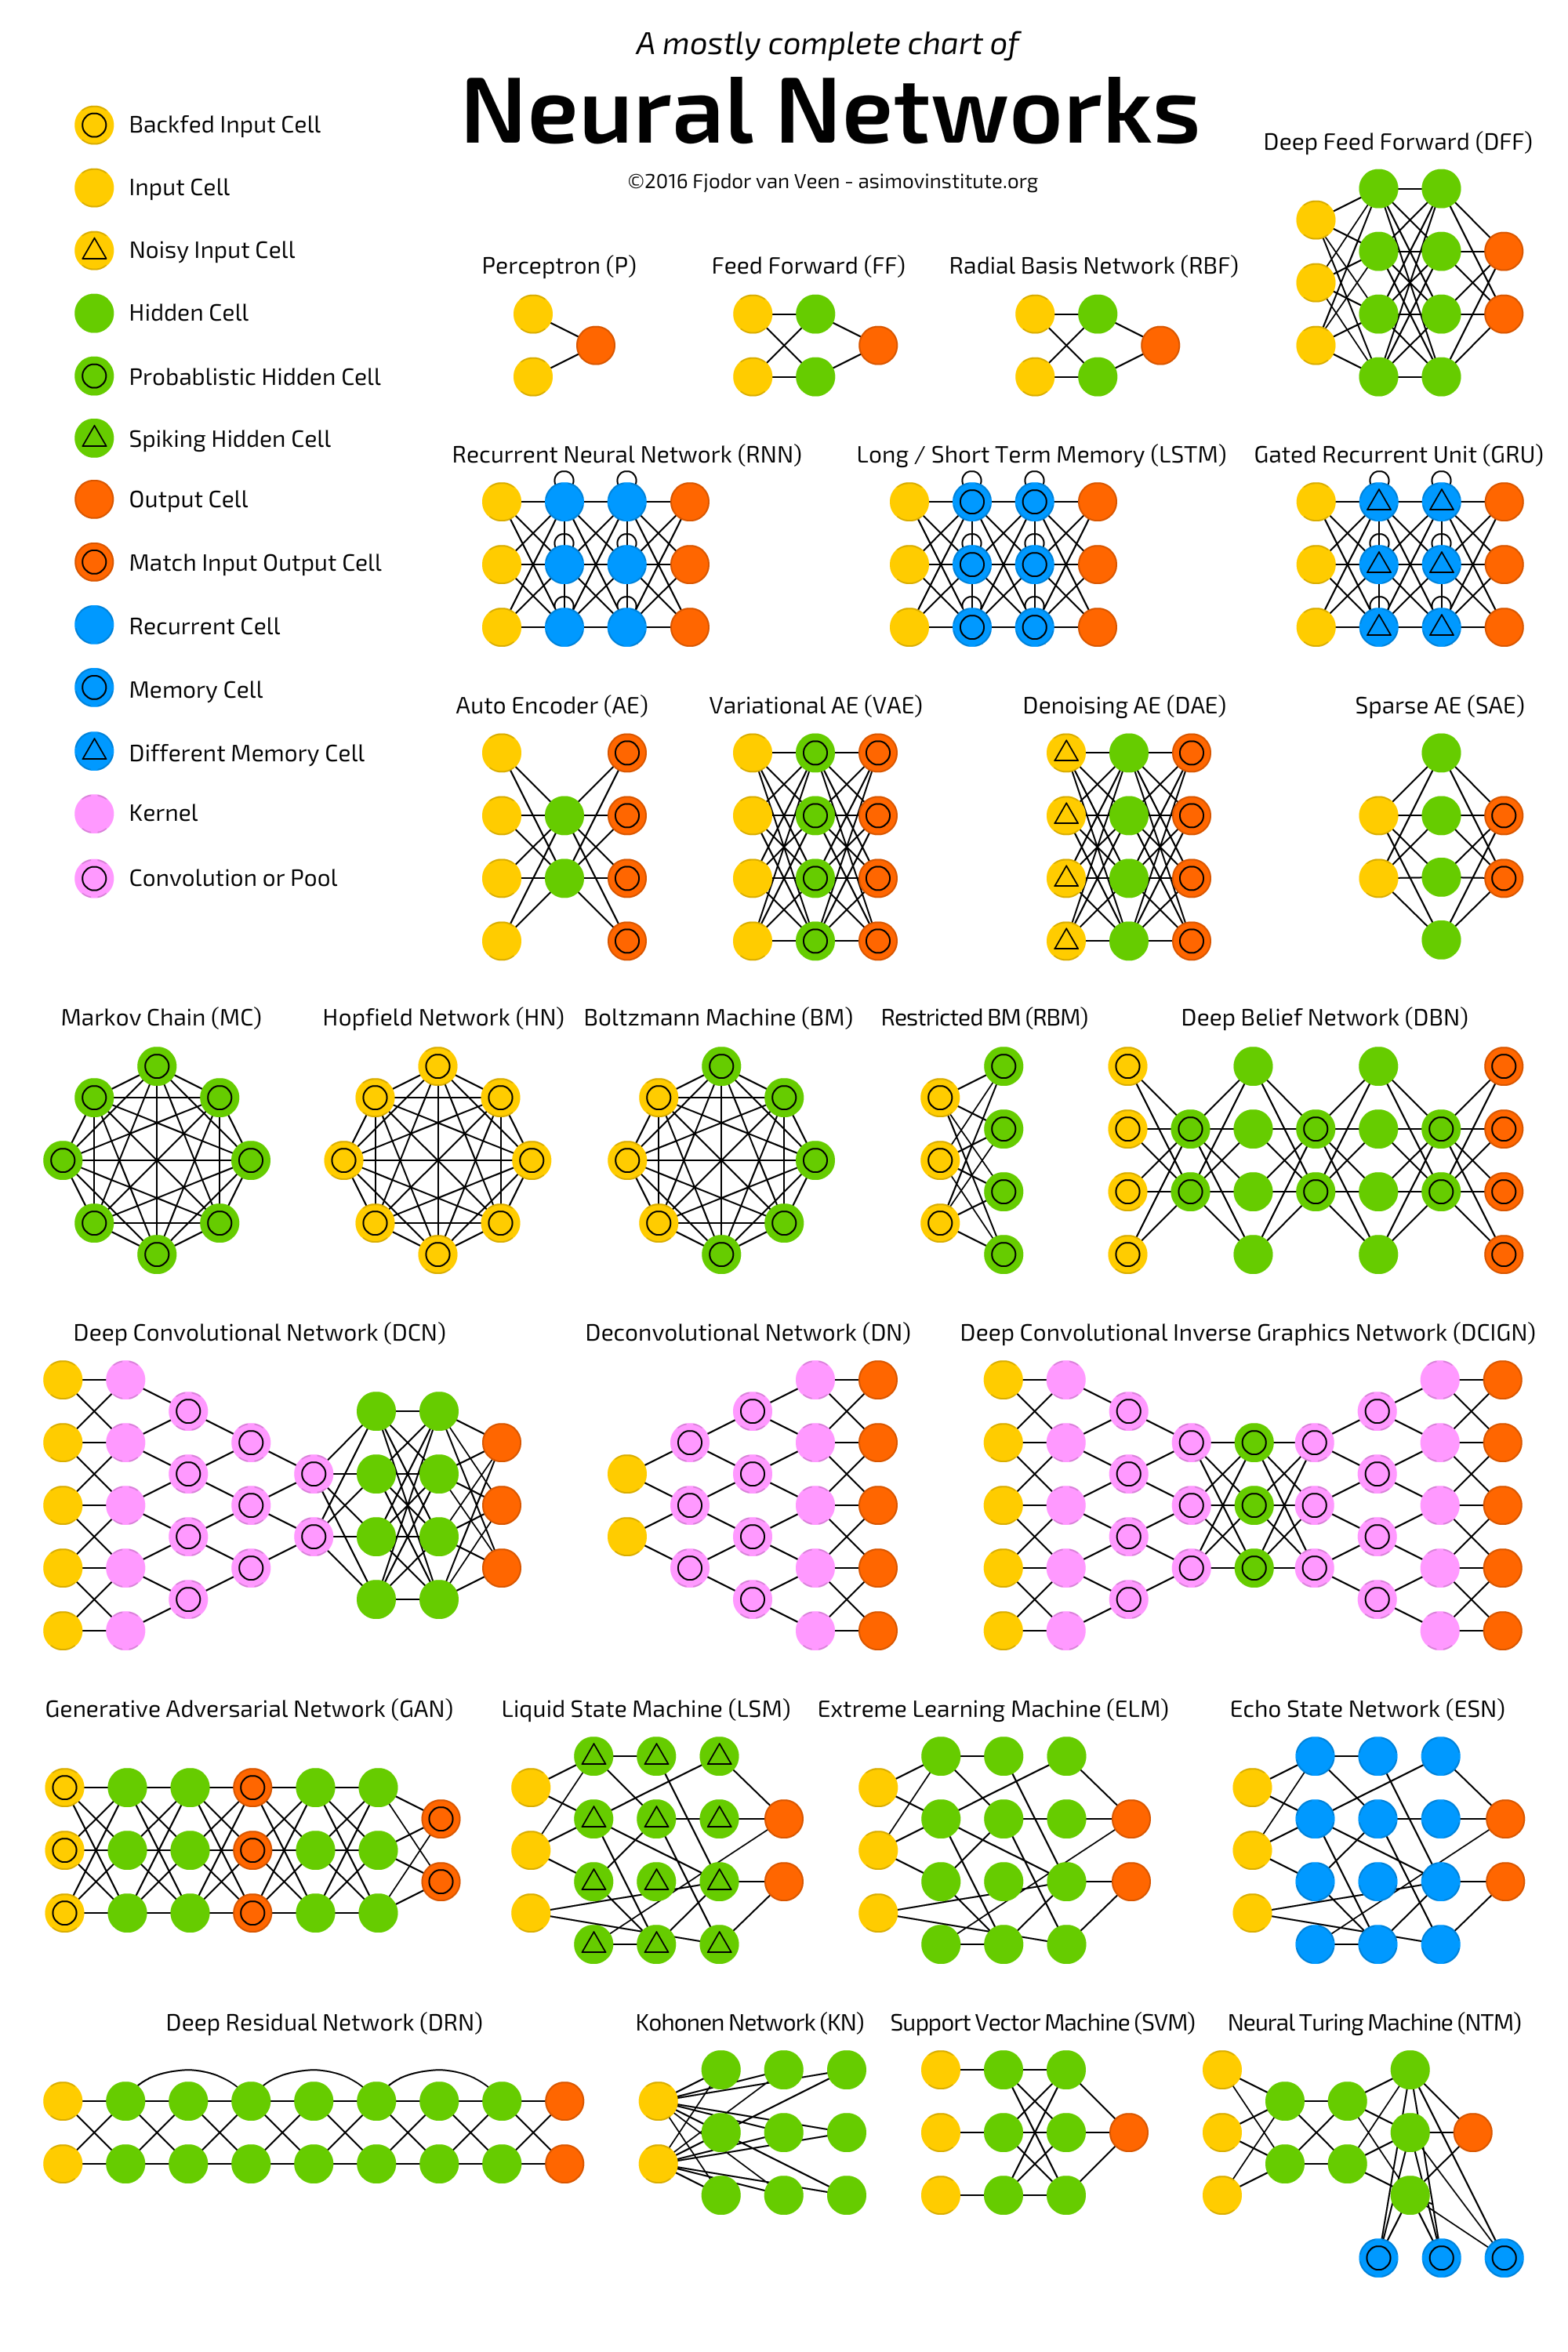

In [254]:
document_name = "zoo.png"
file_location=paste(getwd(),"/", document_name, sep= "")
display_png(file=file_location, width = 800, height = 800) 

#### The simplest multi-layer perceptron (also known as perceptron) 

It consists of an input layer with n covariates and an output layer with one output neuron. It calculates the function

$$o(\bf{x}) = f\left(w_0 + \sum_{i=1}^n w_ix_i\right)$$

where $w_0$ denotes the intercept, $w = (w_1,. . .,w_n)$ the vector consisting of all synaptic weights without the intercept, and $x = (x_1,. . ., x_n)$ the vector of all covariates. The function is mathematically equivalent to that of GLM with link function $f^{-1}$.
__Therefore, all calculated weights are in this case equivalent to the regression parameters of the GLM__

__To increase the modeling flexibility, hidden layers can be included:__

$$o(\bf{x}) = f\left(w_0 + \sum_{j=1}^J w_j \cdot f\left( W_{0j} + \sum_{i=1}^n w_{ij}x_i\right) \right)$$


where $w_0$ denotes the intercept of the output neuron and $w_{0j}$ the intercept of the j'th hidden neuron. Additionally, $wj$ denotes the synaptic weight corresponding to the synapse starting at the j'th hidden neuron and leading to the output neuron, 
$wj = (w_{1j},. . .,w_{nj})$ the vector of all synaptic weights corresponding to the synapses leading to the j'th hidden neuron, and $x = (x_1,. . ., x_n)$ the vector of all covariates.
__This shows that neural networks are direct extensions of GLMs. However, the parameters, i.e. the weights, cannot be interpreted in the same way anymore__

#### Backpropagation and resilient backpropagation
The resilient backpropagation algorithm is based on the traditional backpropagation algorithm that modifies the weights of a neural network in order to find a local minimum of the error function. Therefore, the gradient of the error function (dE/dw) is calculated with respect to the weights in order to find a root. In particular, the weights are modified going in the opposite
direction of the partial derivatives until a local minimum is reached. This basic idea is roughly illustrated in the below figure for a univariate error-function.


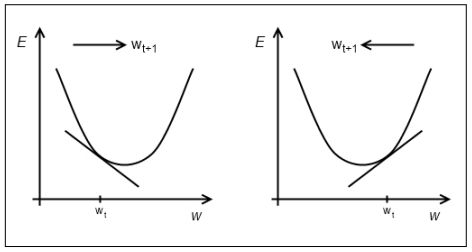

In [258]:
document_name = "backpropagation.png"
file_location=paste(getwd(),"/", document_name, sep= "")
display_png(file=file_location, width = 600, height = 600) 

### The model of choice: neuralnet - Training of Neural Networks

__neuralnet__ is built to train multi-layer perceptrons in the context of regression analyses, i.e. to approximate functional  relationships between covariates and response variables. Thus, neural networks are used as extensions of generalized linear models. neuralnet is a very flexible package. The backpropagation algorithm and three versions of resilient backpropagation are implemented and it provides a custom-choice of activation and error function. An arbitrary number of covariates and response variables as well as of hidden layers can theoretically be included. Artificial neural networks can be applied to approximate any complex functional relationship. Unlike generalized linear models (GLM, McCullagh and Nelder, 1983), it is not necessary to
prespecify the type of relationship between covariates and response variables as for instance as linear combination. This makes artificial neural networks a valuable statistical tool. The package neuralnet (Fritsch and Günther,2008) contains a very flexible function to train feedforward neural networks. It can theoretically handle an arbitrary number of covariates and response variables as well as of hidden layers and hidden neurons even though the computational costs can increase exponentially with higher order of complexity. This can cause an early stop of the iteration process since the maximum of iteration steps,
which can be defined by the user, is reached before the algorithm converges. __neuralnet__ was built to train neural networks in the context of regression analyses. Thus, resilient backpropagation is used since this algorithm is still one of the fastest algorithms for this purpose

## Training of neural networks

The function neuralnet used for training a neural network provides the opportunity to define the required number of hidden layers and hidden neurons according to the needed complexity. The complexity of the calculated function increases with the addition of hidden layers or hidden neurons. The default value is one hidden layer with one hidden neuron. The most important arguments of the function are the following:


- __formula__, a symbolic description of the model to be fitted

- __data__, a data frame containing the variables specified in formula

- __hidden__, a vector specifying the number of hidden layers and hidden neurons in each layer. For example the vector (3,2,1) induces a neural network with three hidden layers, the first one with three, the second one with two and the third one with one hidden neuron. 
- __threshold__, an integer specifying the threshold for the partial derivatives of the error function as stopping criteria. Default: 0.01.

- __rep__, number of repetitions for the training process. Default: 1

- __startweights__, a vector containing prespecified starting values for the weights. Default: random numbers drawn from the standard normal distribution (Note: This is why we need rep >1 to have more variety in results!!!!!)

- __algorithm__, a string containing the algorithm type. Possible values are "backprop","rprop+", "rprop-". "backprop" refers to traditional backpropagation, "rprop+" and "rprop-" refer to resilient backpropagation with and without weight backtracking and "sag" and "slr" refer to the modified globally convergent algorithm (grprop). Default: "rprop+"

- __err.fct__, a differentiable error function. The strings "sse" and "ce" can be used, which refer to ’sum of squared errors’ and ’cross entropy’. Default: "sse"

- __act.fct__, a differentiable activation function. The strings "logistic" and "tanh" are possible for the logistic function and tangent hyperbolicus. Default: "logistic"

- __linear.output__, logical. If act.fct should not be applied to the output neurons, linear.output has to be TRUE. Default: TRUE


#### Plot of a trained neural network 
including trained synaptic weights and basic information about the training process. It reflects the structure of the trained neural network, i.e. the network topology. The plot includes by default the trained synaptic weights, all intercepts as well as basic information about the training process like the overall error and the number of steps needed to converge. Especially for larger neural networks, the size of the plot and that of each neuron can be determined using the parameters dimension and radius, respectively.

The black lines show the connections between each layer and the weights on each connection while the blue lines show the bias term added in each step. The bias can be thought as the intercept of a linear model.
The net is essentially a black box so we cannot say that much about the fitting, the weights and the model. Suffice to say that the training algorithm has converged and therefore the model is ready to be used.

In [239]:
#Plot function of neural net
plot.nn <-
function (x, rep = NULL, x.entry = NULL, x.out = NULL, radius = 0.15, 
    arrow.length = 0.3, intercept = TRUE, intercept.factor = 0.4, #arrow.length = 0.2 default
    information = TRUE, information.pos = 0.1, col.entry.synapse = "black", 
    col.entry = "black", col.hidden = "black", col.hidden.synapse = "black", 
    col.out = "black", col.out.synapse = "black", col.intercept = "blue", 
    fontsize = 8, dimension = 5, show.weights = TRUE, file = NULL, #fontsize 12 default, dimension = 6 default
    ...) 
{
    net <- x
    if (is.null(net$weights)) 
        stop("weights were not calculated")
    if (!is.null(file) && !is.character(file)) 
        stop("'file' must be a string")
    if (is.null(rep)) {
        for (i in 1:length(net$weights)) {
            if (!is.null(file)) 
                file.rep <- paste(file, ".", i, sep = "")
            else file.rep <- NULL
            #dev.new()
            plot.nn(net, rep = i, x.entry, x.out, radius, arrow.length, 
                intercept, intercept.factor, information, information.pos, 
                col.entry.synapse, col.entry, col.hidden, col.hidden.synapse, 
                col.out, col.out.synapse, col.intercept, fontsize, 
                dimension, show.weights, file.rep, ...)
        }
    }
    else {
        if (is.character(file) && file.exists(file)) 
            stop(sprintf("%s already exists", sQuote(file)))
        result.matrix <- t(net$result.matrix)
        if (rep == "best") 
            rep <- as.integer(which.min(result.matrix[, "error"]))
        if (rep > length(net$weights)) 
            stop("'rep' does not exist")
        weights <- net$weights[[rep]]
        if (is.null(x.entry)) 
            x.entry <- 0.5 - (arrow.length/2) * length(weights)
        if (is.null(x.out)) 
            x.out <- 0.5 + (arrow.length/2) * length(weights)
        width <- max(x.out - x.entry + 0.2, 0.8) * 8
        radius <- radius/dimension
        entry.label <- net$model.list$variables
        out.label <- net$model.list$response
        neuron.count <- array(0, length(weights) + 1)
        neuron.count[1] <- nrow(weights[[1]]) - 1
        neuron.count[2] <- ncol(weights[[1]])
        x.position <- array(0, length(weights) + 1)
        x.position[1] <- x.entry
        x.position[length(weights) + 1] <- x.out
        if (length(weights) > 1) 
            for (i in 2:length(weights)) {
                neuron.count[i + 1] <- ncol(weights[[i]])
                x.position[i] <- x.entry + (i - 1) * (x.out - 
                  x.entry)/length(weights)
            }
        y.step <- 1/(neuron.count + 1)
        y.position <- array(0, length(weights) + 1)
        y.intercept <- 1 - 2 * radius
        information.pos <- min(min(y.step) - 0.1, 0.2)
        if (length(entry.label) != neuron.count[1]) {
            if (length(entry.label) < neuron.count[1]) {
                tmp <- NULL
                for (i in 1:(neuron.count[1] - length(entry.label))) {
                  tmp <- c(tmp, "no name")
                }
                entry.label <- c(entry.label, tmp)
            }
        }
        if (length(out.label) != neuron.count[length(neuron.count)]) {
            if (length(out.label) < neuron.count[length(neuron.count)]) {
                tmp <- NULL
                for (i in 1:(neuron.count[length(neuron.count)] - 
                  length(out.label))) {
                  tmp <- c(tmp, "no name")
                }
                out.label <- c(out.label, tmp)
            }
        }
        grid.newpage()
        pushViewport(viewport(name = "plot.area", width = unit(dimension, 
            "inches"), height = unit(dimension, "inches")))
        for (k in 1:length(weights)) {
            for (i in 1:neuron.count[k]) {
                y.position[k] <- y.position[k] + y.step[k]
                y.tmp <- 0
                for (j in 1:neuron.count[k + 1]) {
                  y.tmp <- y.tmp + y.step[k + 1]
                  result <- calculate.delta(c(x.position[k], 
                    x.position[k + 1]), c(y.position[k], y.tmp), 
                    radius)
                  x <- c(x.position[k], x.position[k + 1] - result[1])
                  y <- c(y.position[k], y.tmp + result[2])
                  grid.lines(x = x, y = y, arrow = arrow(length = unit(0.15, 
                    "cm"), type = "closed"), gp = gpar(fill = col.hidden.synapse, 
                    col = col.hidden.synapse, ...))
                  if (show.weights) 
                    draw.text(label = weights[[k]][neuron.count[k] - 
                      i + 2, neuron.count[k + 1] - j + 1], x = c(x.position[k], 
                      x.position[k + 1]), y = c(y.position[k], 
                      y.tmp), xy.null = 1.25 * result, color = col.hidden.synapse, 
                      fontsize = fontsize - 2, ...)
                }
                if (k == 1) {
                  grid.lines(x = c((x.position[1] - arrow.length), 
                    x.position[1] - radius), y = y.position[k], 
                    arrow = arrow(length = unit(0.15, "cm"), 
                      type = "closed"), gp = gpar(fill = col.entry.synapse, 
                      col = col.entry.synapse, ...))
                  draw.text(label = entry.label[(neuron.count[1] + 
                    1) - i], x = c((x.position - arrow.length), 
                    x.position[1] - radius), y = c(y.position[k], 
                    y.position[k]), xy.null = c(0, 0), color = col.entry.synapse, 
                    fontsize = fontsize, ...)
                  grid.circle(x = x.position[k], y = y.position[k], 
                    r = radius, gp = gpar(fill = "white", col = col.entry, 
                      ...))
                }
                else {
                  grid.circle(x = x.position[k], y = y.position[k], 
                    r = radius, gp = gpar(fill = "white", col = col.hidden, 
                      ...))
                }
            }
        }
        out <- length(neuron.count)
        for (i in 1:neuron.count[out]) {
            y.position[out] <- y.position[out] + y.step[out]
            grid.lines(x = c(x.position[out] + radius, x.position[out] + 
                arrow.length), y = y.position[out], arrow = arrow(length = unit(0.15, 
                "cm"), type = "closed"), gp = gpar(fill = col.out.synapse, 
                col = col.out.synapse, ...))
            draw.text(label = out.label[(neuron.count[out] + 
                1) - i], x = c((x.position[out] + radius), x.position[out] + 
                arrow.length), y = c(y.position[out], y.position[out]), 
                xy.null = c(0, 0), color = col.out.synapse, fontsize = fontsize, 
                ...)
            grid.circle(x = x.position[out], y = y.position[out], 
                r = radius, gp = gpar(fill = "white", col = col.out, 
                  ...))
        }
        if (intercept) {
            for (k in 1:length(weights)) {
                y.tmp <- 0
                x.intercept <- (x.position[k + 1] - x.position[k]) * 
                  intercept.factor + x.position[k]
                for (i in 1:neuron.count[k + 1]) {
                  y.tmp <- y.tmp + y.step[k + 1]
                  result <- calculate.delta(c(x.intercept, x.position[k + 
                    1]), c(y.intercept, y.tmp), radius)
                  x <- c(x.intercept, x.position[k + 1] - result[1])
                  y <- c(y.intercept, y.tmp + result[2])
                  grid.lines(x = x, y = y, arrow = arrow(length = unit(0.15, 
                    "cm"), type = "closed"), gp = gpar(fill = col.intercept, 
                    col = col.intercept, ...))
                  xy.null <- cbind(x.position[k + 1] - x.intercept - 
                    2 * result[1], -(y.tmp - y.intercept + 2 * 
                    result[2]))
                  if (show.weights) 
                    draw.text(label = weights[[k]][1, neuron.count[k + 
                      1] - i + 1], x = c(x.intercept, x.position[k + 
                      1]), y = c(y.intercept, y.tmp), xy.null = xy.null, 
                      color = col.intercept, alignment = c("right", 
                        "bottom"), fontsize = fontsize - 2, ...)
                }
                grid.circle(x = x.intercept, y = y.intercept, 
                  r = radius, gp = gpar(fill = "white", col = col.intercept, 
                    ...))
                grid.text(1, x = x.intercept, y = y.intercept, 
                  gp = gpar(col = col.intercept, ...))
            }
        }
        if (information) 
            grid.text(paste("Error: ", round(result.matrix[rep, 
                "error"], 6), "   Steps: ", result.matrix[rep, 
                "steps"], sep = ""), x = 0.5, y = information.pos, 
                just = "bottom", gp = gpar(fontsize = fontsize + 
                  2, ...))
        popViewport()
        if (!is.null(file)) {
            weight.plot <- recordPlot()
            save(weight.plot, file = file)
        }
    }
}
calculate.delta <-
function (x, y, r) 
{
    delta.x <- x[2] - x[1]
    delta.y <- y[2] - y[1]
    x.null <- r/sqrt(delta.x^2 + delta.y^2) * delta.x
    if (y[1] < y[2]) 
        y.null <- -sqrt(r^2 - x.null^2)
    else if (y[1] > y[2]) 
        y.null <- sqrt(r^2 - x.null^2)
    else y.null <- 0
    c(x.null, y.null)
}
draw.text <-
function (label, x, y, xy.null = c(0, 0), color, alignment = c("left", 
    "bottom"), ...) 
{
    x.label <- x[1] + xy.null[1]
    y.label <- y[1] - xy.null[2]
    x.delta <- x[2] - x[1]
    y.delta <- y[2] - y[1]
    angle = atan(y.delta/x.delta) * (180/pi)
    if (angle < 0) 
        angle <- angle + 0
    else if (angle > 0) 
        angle <- angle - 0
    if (is.numeric(label)) 
        label <- round(label, 5)
    pushViewport(viewport(x = x.label, y = y.label, width = 0, 
        height = , angle = angle, name = "vp1", just = alignment))
    grid.text(label, x = 0, y = unit(0.75, "mm"), just = alignment, 
        gp = gpar(col = color, ...))
    popViewport()
}

### Creating the formula

In [ ]:
col_list <- paste(c(colnames(ABT_features[,-1])),collapse="+")#no date
col_list <- paste(c("Q1_forecast + Q2_forecast + Q3_forecast + Q4_forecast ~",col_list),collapse="")
f <- formula(col_list)

### Linear Model

In [383]:
results = list()
repetitions = 20
res = list()
for(j in 1:23){
nmodel <- neuralnet(f,data=df_complete_scaled[(nrow(df_complete_scaled)-10-j):nrow(df_complete_scaled),],hidden=0, 
                    rep = repetitions,
                    linear.output = TRUE,#T for regression, F for [0,1] interval (aka classification)
                    threshold = 0.01,
                    learningrate.limit = NULL,
                    learningrate.factor =list(minus = 0.5, plus = 1.2),
                    algorithm = "rprop+"
                   )
res = list()
for(i in 1:repetitions){
temp <- compute(nmodel, df_complete_scaled[(nrow(df_complete_scaled)-10-j-1),c(colnames(ABT_features[,-1]))],
                  rep = i
                  #rep = as.numeric(which(nmodel$result.matrix[1,] == min(nmodel$result.matrix[1,]), arr.ind = TRUE)))#get best rep
                  )
res = rbind(res,temp$net.result)
}
results = rbind(results, colMeans(matrix(sapply(res, as.numeric),ncol=4)))
}
results = as.data.frame(results)
colnames(results) = c("Q1_predicted", "Q2_predicted", "Q3_predicted", "Q4_predicted")
results = results[seq(dim(results)[1],1),]#reverse order!
benchmark = df_complete_scaled[1:(nrow(df_complete_scaled)-10-1-1),c("Q1_forecast", "Q2_forecast", "Q3_forecast", "Q4_forecast")]

# TO DO: Confidence Intervals!

In [421]:
res = list()
j = 22
i=1
temp <- compute(nmodel, df_complete_scaled[(nrow(df_complete_scaled)-10-j-1),c(colnames(ABT_features[,-1]))],
                  rep = i
                  #rep = as.numeric(which(nmodel$result.matrix[1,] == min(nmodel$result.matrix[1,]), arr.ind = TRUE)))#get best rep
                  )
res = rbind(res,temp$net.result)

In [424]:
#hist(matrix(sapply(res, as.numeric),ncol=4)[,1])

### Results (Linear Model)

In [384]:
#results(run above code with hidden = 0 for linear model (OLS))
transform_back = function(x){
    temp = exp(x)/(1+exp(x))
    return(temp)
}

Q1_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q1_predicted)))-transform_back(benchmark$Q1_forecast))^2))
Q2_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q2_predicted)))-transform_back(benchmark$Q2_forecast))^2))
Q3_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q3_predicted)))-transform_back(benchmark$Q3_forecast))^2))
Q4_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q4_predicted)))-transform_back(benchmark$Q4_forecast))^2))

cat("Q1_forecast_error (RMSE) for AR: ", round(Q1_forecast_error,4), "\n","\n")
cat("Q2_forecast_error (RMSE) for AR: ", round(Q2_forecast_error,4), "\n","\n")
cat("Q3_forecast_error (RMSE) for AR: ", round(Q3_forecast_error,4), "\n","\n")
cat("Q4_forecast_error (RMSE) for AR: ", round(Q4_forecast_error,4), "\n","\n")


Q1_forecast_error (RMSE) for AR:  0.1394 
 
Q2_forecast_error (RMSE) for AR:  0.1268 
 
Q3_forecast_error (RMSE) for AR:  0.1311 
 
Q4_forecast_error (RMSE) for AR:  0.1379 
 


### Plot Neural Network

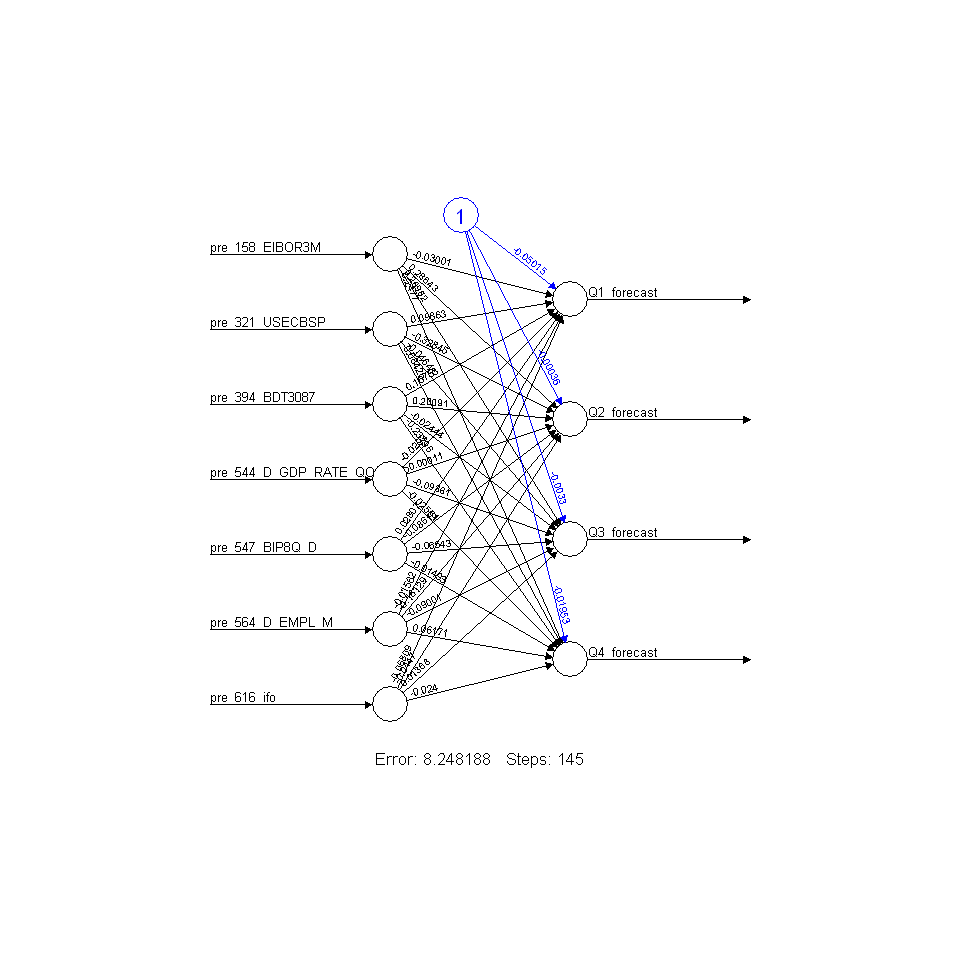

In [376]:
plot.nn(nmodel, rep = as.numeric(which(nmodel$result.matrix[1,] == min(nmodel$result.matrix[1,]), arr.ind = TRUE)))

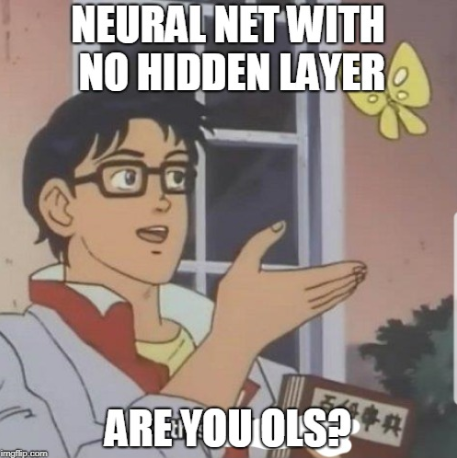

In [322]:
document_name = "meme.png"
file_location=paste(getwd(),"/", document_name, sep= "")
display_png(file=file_location, width = 400, height = 400)  

### Non-linear Model

In [395]:
results = list()
repetitions = 20
res = list()
for(j in 1:23){
nmodel <- neuralnet(f,data=df_complete_scaled[(nrow(df_complete_scaled)-10-j):nrow(df_complete_scaled),],hidden=1, 
                    rep = repetitions,
                    linear.output = TRUE,#T for regression, F for [0,1] interval (aka classification)
                    threshold = 0.01,
                    learningrate.limit = NULL,
                    learningrate.factor =list(minus = 0.5, plus = 1.2),
                    algorithm = "rprop+"
                   )
res = list()
for(i in 1:repetitions){
temp <- compute(nmodel, df_complete_scaled[(nrow(df_complete_scaled)-10-j-1),c(colnames(ABT_features[,-1]))],
                  rep = i
                  #rep = as.numeric(which(nmodel$result.matrix[1,] == min(nmodel$result.matrix[1,]), arr.ind = TRUE)))#get best rep
                  )
res = rbind(res,temp$net.result)
}
results = rbind(results, colMeans(matrix(sapply(res, as.numeric),ncol=4)))
    }
results = as.data.frame(results)
colnames(results) = c("Q1_predicted", "Q2_predicted", "Q3_predicted", "Q4_predicted")
results = results[seq(dim(results)[1],1),]#reverse order!
benchmark = df_complete_scaled[1:(nrow(df_complete_scaled)-10-1-1),c("Q1_forecast", "Q2_forecast", "Q3_forecast", "Q4_forecast")]

### Results of Non-linear Model

In [396]:
#results(run above code with hidden = c(5,3) f.ex for nonlinear model)
transform_back = function(x){
    temp = exp(x)/(1+exp(x))
    return(temp)
}

Q1_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q1_predicted)))-transform_back(benchmark$Q1_forecast))^2))
Q2_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q2_predicted)))-transform_back(benchmark$Q2_forecast))^2))
Q3_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q3_predicted)))-transform_back(benchmark$Q3_forecast))^2))
Q4_forecast_error = sqrt(mean((transform_back(as.vector(unlist(results$Q4_predicted)))-transform_back(benchmark$Q4_forecast))^2))

cat("Q1_forecast_error (RMSE) for AR: ", round(Q1_forecast_error,4), "\n","\n")
cat("Q2_forecast_error (RMSE) for AR: ", round(Q2_forecast_error,4), "\n","\n")
cat("Q3_forecast_error (RMSE) for AR: ", round(Q3_forecast_error,4), "\n","\n")
cat("Q4_forecast_error (RMSE) for AR: ", round(Q4_forecast_error,4), "\n","\n")

Q1_forecast_error (RMSE) for AR:  0.116 
 
Q2_forecast_error (RMSE) for AR:  0.1087 
 
Q3_forecast_error (RMSE) for AR:  0.1195 
 
Q4_forecast_error (RMSE) for AR:  0.1123 
 


### Plot Neural Network for Non-linear model

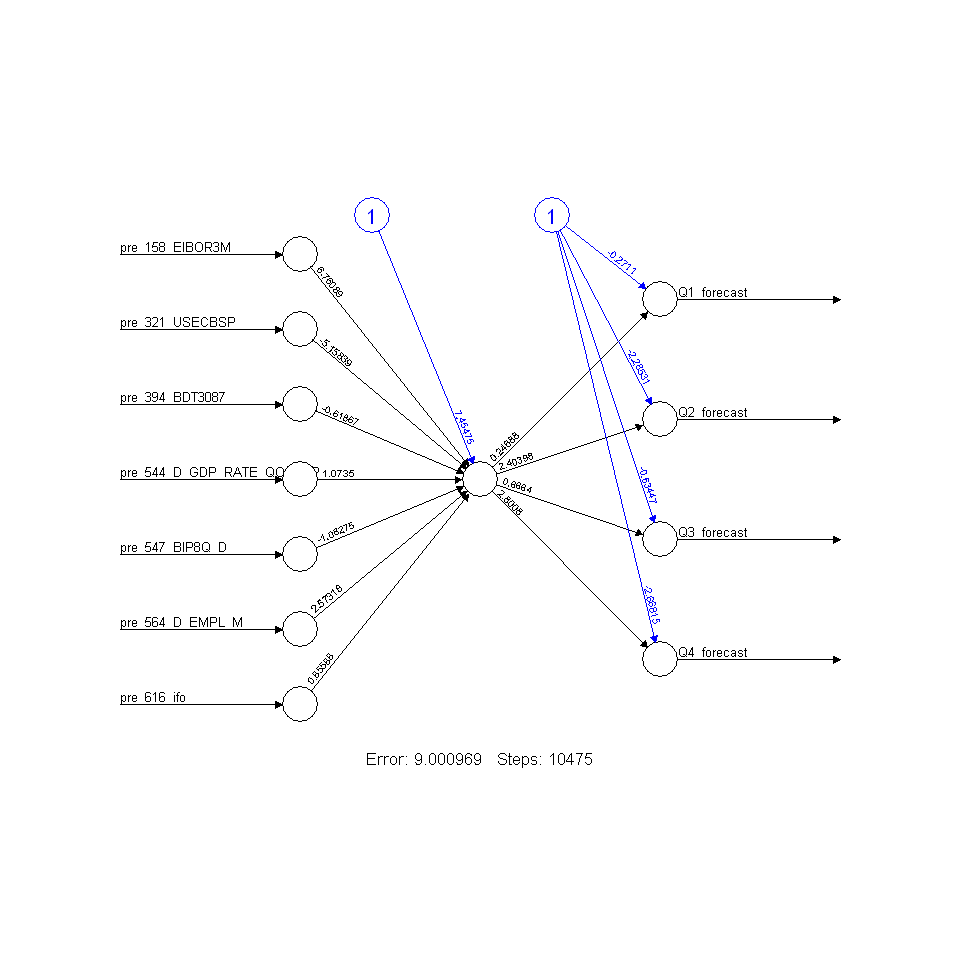

In [397]:
plot.nn(nmodel, rep = as.numeric(which(nmodel$result.matrix[1,] == min(nmodel$result.matrix[1,]), arr.ind = TRUE)))

### A final note on model interpretability
Neural networks resemble black boxes a lot: explaining their outcome is much more difficult than explaining the outcome of simpler model such as a linear model. Therefore, depending on the kind of application you need, you might want to take into account this factor too. Furthermore, as you have seen above, extra care is needed to fit a neural network and small changes can lead to different results.

### Simple models using target variable only

### 3.1 Naive Model (This will be our benchmark)¶
- Always start with a naive approach to get the baseline error that you can measure up against future models

- Last observation carrying forward as prediction (Reason: if no indication on trend available, take the last obs, as it contains most information that you can act upon

In [ ]:
baseline_df = data.frame( ABT%>%filter(Date <"2015-09-30" & Date >"2009-09-30")%>%select(pre_45_CRPh_Delta_Logit_AR_1Q),
                          ABT%>%filter(Date <"2015-09-30" & Date >"2009-09-30")%>%select(pre_45_CRPh_Delta_Logit_AR_1Q),
                          ABT%>%filter(Date <"2015-09-30" & Date >"2009-09-30")%>%select(pre_45_CRPh_Delta_Logit_AR_1Q),
                          ABT%>%filter(Date <"2015-09-30" & Date >"2009-09-30")%>%select(pre_45_CRPh_Delta_Logit_AR_1Q))
colnames(baseline_df) = c("Q1_predicted", "Q2_predicted", "Q3_predicted", "Q4_predicted")
benchmark = df_complete_scaled[1:(nrow(df_complete_scaled)-10-1-1),c("Q1_forecast", "Q2_forecast", "Q3_forecast", "Q4_forecast")]

### Results of Naive Model

In [358]:
transform_back = function(x){
    temp = exp(x)/(1+exp(x))
    return(temp)
}

Q1_forecast_error = sqrt(mean((transform_back(as.vector(unlist(baseline_df$Q1_predicted)))-transform_back(benchmark$Q1_forecast))^2))
Q2_forecast_error = sqrt(mean((transform_back(as.vector(unlist(baseline_df$Q2_predicted)))-transform_back(benchmark$Q2_forecast))^2))
Q3_forecast_error = sqrt(mean((transform_back(as.vector(unlist(baseline_df$Q3_predicted)))-transform_back(benchmark$Q3_forecast))^2))
Q4_forecast_error = sqrt(mean((transform_back(as.vector(unlist(baseline_df$Q4_predicted)))-transform_back(benchmark$Q4_forecast))^2))

cat("Q1_forecast_error (RMSE) for AR: ", round(Q1_forecast_error,4), "\n","\n")
cat("Q2_forecast_error (RMSE) for AR: ", round(Q2_forecast_error,4), "\n","\n")
cat("Q3_forecast_error (RMSE) for AR: ", round(Q3_forecast_error,4), "\n","\n")
cat("Q4_forecast_error (RMSE) for AR: ", round(Q4_forecast_error,4), "\n","\n")


Q1_forecast_error (RMSE) for AR:  0.1665 
 
Q2_forecast_error (RMSE) for AR:  0.1191 
 
Q3_forecast_error (RMSE) for AR:  0.1485 
 
Q4_forecast_error (RMSE) for AR:  0.1596 
 


In [ ]:
#END

### APPENDIX

In [ ]:
for(i in 1:23){
nmodel <- neuralnet(f,data=df_complete_scaled[(nrow(df_complete_scaled)-10-i):nrow(df_complete_scaled),],hidden=c(5,3), 
                    rep = repetitions,
                    linear.output = TRUE,#T for regression, F for [0,1] interval (aka classification)
                    threshold = 0.01,
                    learningrate.limit = NULL,
                    learningrate.factor =list(minus = 0.5, plus = 1.2),
                    algorithm = "rprop+"
                   )
res = list()
for(i in 1:repetitions){
temp <- compute(nmodel, df_complete_scaled[(nrow(df_complete_scaled)-10-i-1),c(colnames(ABT_features[,-1]))],
                  rep = i
                  #rep = as.numeric(which(nmodel$result.matrix[1,] == min(nmodel$result.matrix[1,]), arr.ind = TRUE)))#get best rep
                  )
res = rbind(res,temp$net.result)
}
results = rbind(results, colMeans(matrix(sapply(res, as.numeric),ncol=4)))
    }
results = as.data.frame(results)
colnames(results) = c("Q1_predicted", "Q2_predicted", "Q3_predicted", "Q4_predicted")
results = results[seq(dim(results)[1],1),]#reverse order!

In [355]:
Mean_Model = meanf(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q),4)# h = 4steps

### 3.2 Naive Method

- Forecasts equal to the last observed value

$$\hat{y_{n+h|n}} :=  y_n$$

In [339]:
Naive_Model = naive(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q),4)

### 2.3 Other Methods (tbd)

In [361]:
Exponential_Smoothing = ses(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q),4)

In [365]:
Holt_Winter = holt(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q),4)

In [375]:
Theta_Method = thetaf(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q),4)

In [381]:
Forecast_Method = forecast(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q),4)

In [388]:
ARIMA_Method = forecast(auto.arima(rev(df[[24]]$pre_45_CRPh_Delta_Logit_AR_1Q)),4)

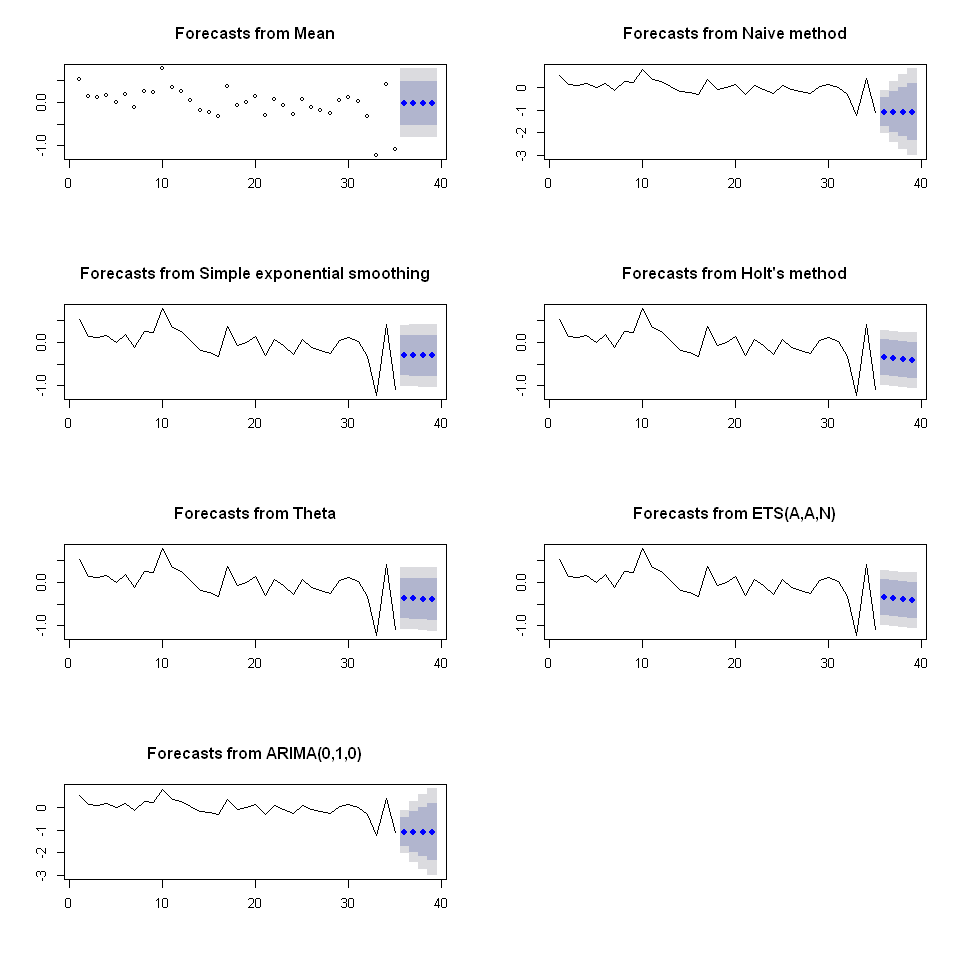

In [393]:
options(repr.plot.width = 8)#7 is default
options(repr.plot.height = 8)#7 is default
par(mfrow=c(4,2))
plot(Mean_Model)
plot(Naive_Model)
plot(Exponential_Smoothing)#Exponential Trend Smoothing
plot(Holt_Winter)
plot(Theta_Method)
plot(Forecast_Method)
plot(ARIMA_Method)

## Measuring Forecast Accuracy

Let $y_t$ denote the t'th observation and $f_t$ denote its forecast, where $t = 1, ..., n$ then the following measures are useful:

$$\text{RMSE} =  \sqrt{n^{-1}\sum_{t=1}^n (y_t-f_t)^2} $$

__Caveat:__ RMSE is scale dependent

Alternative: MASE (Mean Absolute Scaled Error)

$$\text{MASE} =  n^{-1}\sum_{t=1}^n \frac{|y_t-f_t|}{q} $$ 
where q is a stable measure of the scale of the time series. For non-seasonal time series:
$$q = (n-1)^{-1}\sum_{t=2}^n|y_t - f_t|$$

# Modelling Part 2: 

You can use for example the package randomForestSRC or MultivariateRandomForest in R for your purpose, they both provide an implementation of random forest for multivariate regression, which is your aim here.

# Conclusion (tbd)

On the mission to model the default rate, our data set that we use to train and test on is quite sparse. Missing data is a significant problem, because we have only AR values on a quarterly basis. Therefore, filling in this missing data is crucial to achieve a high modeling score. As a result, I think that feature engineering and missing data imputation are significantly more important for doing well than the actual modelling part. At least, one can argue that the modeling score is highly sensitive to each individual datapoint. Given this small dataset each point has relatively high "value" which makes overfitting very easy, i.e. modeling for robust results very hard. 
If we were to simply exclude data points from our analyic base table, we would leave a lot of crucial information on the table.

But filling in missing data in this dataset is not so trivial. Some of the variables have missing data for almost every observation. Some variables have a considerable number of missing values. And some variables have only a small number of missing values. With the assistance of the mice package, we are going to do some extensive imputation on this dataset.

In [86]:
#END